--- 

># **코드설명**

---

- 파 일 명 : 3. 펭귄 몸무게 예측 경진대회 (Dacon) <br>
- 시작날짜 : 2021.12.28 <br>
- 수정날짜 : 2021.12028 <br>
- 작 성 자 : 김혁진 <br>
- 작성주제 : 펭귄 몸무게 예측 <br>

--- 

- **참조**

  (1) 대회 홈페이지 : [Dacon](https://dacon.io/competitions/official/235862/overview/description) <br>
  (2) 하이퍼 파리미터 설명 : [Naver Blog](https://blog.naver.com/wideeyed/221333529176) <br>
  (3) Class문 설명 : [Github](https://zzsza.github.io/development/2020/07/05/python-class/) <br>
  (4) GPU 설정 : [Medium](https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af) <br>
  (5) RAM 모두사용으로 세션다운 : [Tistory](https://somjang.tistory.com/entry/Google-Colab-%EC%9E%90%EC%A3%BC%EB%81%8A%EA%B8%B0%EB%8A%94-%EB%9F%B0%ED%83%80%EC%9E%84-%EB%B0%A9%EC%A7%80%ED%95%98%EA%B8%B0)

---

- **고려사항** <br>
  (1) AutoEncoder로 파생변수 생성해보기 <br>
  (2) 하이퍼파라미터 탐색 : grid-search, bayesian-optimization, [optuna](https://dacon.io/competitions/official/235713/codeshare/2704?page=1&dtype=recent) <br>
  (3) RandomForest, XGBoost, Lightgbm, CatBoost 설명 [블로그](https://jhkim0759.tistory.com/12)

---

># **기본설정**

## Query Start Time

In [1]:
import time
query_start_time = time.time()

<br></br>
## Markdown : Tabular Left Align

In [2]:
%%html
<style>
    table {float:left}
</style>

<br></br>
## Jupyter Notebook Style : Theme, Display

In [3]:
# # theme 설치
# !pip install jupyterthemes

# # jupyter notebook 최신버전
# !pip install --upgrade notebook

# # jupyter notebook 최신버전
# !pip install --upgrade jupyterthemes

# 2.2.1. 테마바꾸기(customizing)
# !jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd  -kl -T -N

# 2.2.2. 쥬피터 노트북 화면 넓게 사용
# 출처: https://taehooh.tistory.com/entry/Jupyter-Notebook-주피터노트북-화면-넓게-쓰는방법
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:80% !important; }</style>"))

# # 2.2.3. 좌측 TOC 만들기
# # 출처 : https://gmnam.tistory.com/246
# !pip install jupyter_nbextensions_configurator
# !pip install jupyter_contrib_nbextensions

# !jupyter nbextensions_configurator enable --user
# !jupyter contrib nbextension install --user

In [4]:
# # 2.3.1 Google Drive Mount
# # (Google Drive 사용 시 설정)
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True) # 새로운 창에서 key 를 받아서 입력해야합니다. 

# # 2.3.2. 메모리 에러
# https://growingsaja.tistory.com/477

In [5]:
# # 2.3.3. GPU 사용 (6분)
# !git clone --recursive https://github.com/Microsoft/LightGBM
# !mkdir build
# %cd /content/LightGBM
# !cmake -DUSE_GPU=1 #avoid ..
# !make -j$(nproc)
# !sudo apt-get -y install python-pip
# !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
# %cd /content/LightGBM/python-package

<br></br>
##### Install Modules

In [6]:
# !pip uninstall pandas -y
# !pip uninstall numpy  -y
# !pip uninstall lightgbm -y

# !pip install pandas==1.1.0
# !pip install numpy==1.21.2
# !pip install -U scikit-learn
# !pip install lightgbm --install-option=--gpu

# !pip install pandasql
# !pip install seaborn
# !pip install plotnine
# !pip install pandasql

# lightgbm 에러떴는데, 콘다에서 실행하면 해결됨
# conda install -c conda-forge lightgbm 

# bayesian optimization 설치
# !pip install bayesian-optimization

# xgboost 설치
# !pip install xgboost

# catboost 설치
# !pip install catboost

# !pip install dill

# pycaret 에러떴는데, --user 붙이니깐 해결됨
# !pip install --user pycaret

<br></br>
## Import Modules

In [7]:
# jupyter notebook 전용
from tqdm.notebook import tqdm
# from tqdm import tqdm

# basic modules
import pandas as pd
import numpy as np
import math
import warnings
import random
import os
import time
import itertools

# value_counts() 범용적인 버전
from collections import Counter as cnt

# save env.
import dill

# plotting
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 8.27)})
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [11.7, 8.27] # [15, 10] # [11.7,8.27] - A4 size
plt.style.use('dark_background')

from plotnine import *


# sqldf
from pandasql import sqldf
sql = lambda q: sqldf(q, globals())


# modeling
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import f1_score,make_scorer,r2_score
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# import lightgbm
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"
import lightgbm as lgb

# Hyperparameter Optimization
from bayes_opt import BayesianOptimization

<br></br>
## Initial Values

In [8]:
# 2.5.1. Data Path
# jupyter.notebook : 'os.getcwd() + '/DAT/블랙 프라이데이 판매 예측/''
# google.colab     : '/content/drive/MyDrive/Python/4. 블랙프라이데이 판매예측/DAT/'
DATA_PATH = os.getcwd() + '/DAT/3. 펭귄 몸무게 예측 경진대회 (Dacon)/'
OUT_PATH  = os.getcwd() + '/OUT/3. 펭귄 몸무게 예측 경진대회 (Dacon)/'

# 2.5.2. set seed
SEED = 777

# 2.5.3. plot
PLOT = False

# 2.5.5. missing check
MISSING_CHECK = False

# 2.5.6. interaction
INTERACTION_CHECK = False
INTERACTION = True

# 2.5.7. scaling
SCALE_CHECK = False
SCALE = True

# 2.5.8. lightgbm parameter
# 처음 (INIT_POINTS)회 랜덤 값으로 score 계산 후 (N_ITER)회 최적화
INIT_POINTS = 15
N_ITER = 15
N_CV = 4
EARLY_STOPPING_ROUNDS = 30
N_ESTIMATORS = 2000
OBJECTIVE = ['binary','regression'][1]
METRIC = ['auc','binary_logloss','rmse'][2]

# initial value save
ini_var = [
    'SEED','PLOT','SCALE','INTERACTION','MISSING_CHECK','INTERACTION_CHECK',
    'INIT_POINTS','N_ITER','N_CV','EARLY_STOPPING_ROUNDS','N_ESTIMATORS','OBJECTIVE','METRIC'
]

<br></br>
## Set Off the Warning

In [9]:
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

<br></br>
## User Defined Function

In [10]:
#-------------------------------------------------------------------------------------------------------#
# 2.6.1. Seed Fix
#-------------------------------------------------------------------------------------------------------#
def seed_everything(seed: int = 1):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)  # type: ignore
    # torch.backends.cudnn.deterministic = True  # type: ignore
    # torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything(SEED)

#-------------------------------------------------------------------------------------------------------#
# 2.6.2. View all columns
#-------------------------------------------------------------------------------------------------------#
def View(data):

    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    
    print(data)

    pd.set_option('display.max_rows', 0)
    pd.set_option('display.max_columns', 0)
    pd.set_option('display.width', 0)

#-------------------------------------------------------------------------------------------------------#
# 2.6.3. minmax function
#-------------------------------------------------------------------------------------------------------#
def minmax(x, digit=None):
    if round is None:
        return min(x),max(x)
    else:
        return round(min(x),digit),round(max(x),digit)

#-------------------------------------------------------------------------------------------------------#
# 2.6.4. 컬럼dict에서 target 제거
#-------------------------------------------------------------------------------------------------------#
# - dict : 기준 dict
# - key  : 삭제할 key
#-------------------------------------------------------------------------------------------------------#
def rmkey(dict, key):
    tmp = dict.copy()
    del tmp[key]
    return tmp

#-------------------------------------------------------------------------------------------------------#
# 2.6.5. 각 컬럼의 missing 개수를 파악하는 함수
#-------------------------------------------------------------------------------------------------------#
# - data     : 기준 data
# - col_type : {column명 : type}로 이루어진 dictionary
#-------------------------------------------------------------------------------------------------------#
def missing_column_check(df, col_type):
    
    data = df.copy()
    
    n_na = []
    n_na_type = []
    for col_nm in data.columns:
        data[col_nm] = data[col_nm].astype(col_type[col_nm])

        # str인 경우에는 blank(공백)도 있는지 확인
        if col_type[col_nm]==str:

            isnull_cnt = data[col_nm].str.strip().isnull().sum()
            blank_cnt  = sum(data[col_nm].str.strip()=='')
            nan_cnt    = sum(data[col_nm].str.strip()=='nan')
            null_cnt   = sum(data[col_nm].str.strip()=='null')

            n_na_x = isnull_cnt+blank_cnt+nan_cnt+null_cnt
            n_na.append(n_na_x)
            
            if n_na_x>0:
                n_na_type_x=[]
                if isnull_cnt>0: n_na_type_x.append('isnull')
                if blank_cnt >0: n_na_type_x.append('blank')
                if nan_cnt   >0: n_na_type_x.append('nan')
                if null_cnt  >0: n_na_type_x.append('null')
                n_na_type_x = '+'.join(n_na_type_x)
            else:
                n_na_type_x = ''
            n_na_type.append(n_na_type_x)
            

        # numeric인 경우에는 null의 개수만 확인
        else:
            n_na_x = data[col_nm].isnull().sum()
            n_na.append(n_na_x)
            
            if n_na_x>0:
                n_na_type.append('isnull')
            else:
                n_na_type.append('')
            
    res_df = pd.DataFrame({
        'col'  : data.columns,
        'n_na' : n_na,
        'n_n_ratio' : [str(round(n/len(data)*100,1))+'%' for n in n_na],
        'na_type' : n_na_type,
        'col_type' : [COL_TYPE[col].__name__ for col in data.columns]
        })

    res_df = res_df[res_df['n_na']>0]
    if len(res_df)==0:
        return('Dataset does not have a null value')
    else:
        return(res_df)

#-------------------------------------------------------------------------------------------------------#
# 2.6.6. 교호작용항 추가
#-------------------------------------------------------------------------------------------------------#
# - data     : 기준 data
# - num_vari : 숫자형 변수 list
#-------------------------------------------------------------------------------------------------------#
def interaction_term(df,num_vari):
    
    data = df.copy()

    num_var = list(set(num_vari) - set(['id']))

    for i in range(0,len(num_var)):
        for j in range(i,len(num_var)):
            data[f'{num_var[i]}*{num_var[j]}'] = data[f'{num_var[i]}']*data[f'{num_var[j]}']

    return(data)

#-------------------------------------------------------------------------------------------------------#
# 2.6.7. color when print
#-------------------------------------------------------------------------------------------------------#
class color:
    PURPLE    = '\033[95m'
    CYAN      = '\033[96m'
    DARKCYAN  = '\033[36m'
    BLUE      = '\033[94m'
    GREEN     = '\033[92m'
    YELLOW    = '\033[93m'
    RED       = '\033[91m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    END       = '\033[0m'

#-------------------------------------------------------------------------------------------------------#
# 2.6.8. density plot : histogram + density plot
#-------------------------------------------------------------------------------------------------------#
# - data : 기준 data
# - vars : hist + kde를 그릴 숫자형 변수
# - hue  : group화 변수
# - binwidth_adj_ratio : binwidth 조정 비율
#-------------------------------------------------------------------------------------------------------#
def density_plot(df, vars, 
                 binwidths = None, hue = None,
                 binwidth_adj_ratio = None):

    from matplotlib.ticker import PercentFormatter
    
    data = df.copy()

    # 1) vars가 1개뿐일 때 에러발생
    #    -> 1개     : type = str
    #    -> 2개이상 : type = ndarray, ...
    if type(vars)==str:
        vars = [vars]
    
    # 2) plotting (nrow,ncol) 설정
    nrow = math.ceil(len(vars)**(1/2))
    ncol = nrow

    # 3) binwidths가 없을 때, binwidth 설정
    # 출처 : http://www.aistudy.co.kr/paper/pdf/histogram_jeon.pdf
    if binwidths is None:
        binwidths = []
        for col in data[vars].columns:
            n_bin = math.ceil(1 + 3.32*math.log10(len(data)))
            binwidth = ( data[col].max() - data[col].min() ) / n_bin
            binwidths.append(binwidth)
            del binwidth
    
    # 4) 설정한 binwidth를 조정하는 비율
    if binwidth_adj_ratio is not None:
        binwidths = [binwidth * binwidth_adj_ratio for binwidth in binwidths]
    
    fig = plt.figure()
    
    # 5) vars 별로 plot 생성
    for iter,var in enumerate(vars):
        
        binwidth = binwidths[iter]
        
        # (1) histogram
        ax1 = fig.add_subplot(nrow, ncol, iter+1)
        g1 = sns.histplot(data = data, x = var, hue = hue,
                          kde = True, stat = 'probability', 
                          color = 'lightskyblue',
                          binwidth = binwidth, ax = ax1)
        ax2 = ax1.twinx()
        
        # (2) density plot
        g2 = sns.kdeplot(data = data, x = var, hue = hue,
                         color = 'red', lw = 2, ax = ax2)
        ax2.set_ylim(0, ax1.get_ylim()[1] / binwidth)                  # similir limits on the y-axis to align the plots
        #ax2.yaxis.set_major_formatter(PercentFormatter(1 / binwidth))  # show axis such that 1/binwidth corresponds to 100%
        ax2.grid(False)
        
        # (3) density plot y축 없애기
        g2.set(yticklabels=[]) 
        g2.set(ylabel=None)
        g2.tick_params(right=False)
        
        a,b = divmod(iter,ncol)
        if b!=0:
            g1.set(ylabel=None)
        
    # 안겹치도록 설정
    fig.tight_layout()
    plt.show()

# example : density_plot(train, vars=num_vari)

#-------------------------------------------------------------------------------------------------------#
# 2.6.9. density plot : histogram + density plot
#
# (1) grp_var vs hue_var 막대그래프
# (2) grp_var(x축), hue_var에 따른 각 num_var들의 barplot, violineplot, box+swarmplot + kdeplot
#-------------------------------------------------------------------------------------------------------#
#- grp_var : x축 구분할 그룹변수 (text)
#- num_vari : 숫자형 변수 (list)
#- data : 기준 data
#- title_text : plot title (text)
#- hue_var : hue 그루핑변수
#-------------------------------------------------------------------------------------------------------#
def plot_num(grp_var, num_vari, df, title_text=None, hue_var=None):
    
    data = df.copy()
    
    # (1)번 그래프 setting
    fig0 = plt.figure(figsize=(3,3))
    ax0  = fig0.add_subplot(1,1,1)
    
    if title_text is None:
        title_text = grp_var
        
    plt.title(title_text, loc='left', pad=20, fontdict={'fontsize' : 30,
                                                        'fontweight' : 'bold',
                                                        'color' : 'c'})
    
    # grp_var와 hue_var가 겹치는 경우, hue를 나누지 않음
    if (grp_var!=hue_var) and (hue_var is not None):

        ct = pd.crosstab(data[grp_var],data[hue_var])
        ax = ct.plot(kind='bar', stacked=False, rot=0, ax=ax0)
        ax.legend(title=hue_var, bbox_to_anchor=(1, 1.02), loc='upper left')
        
    else:
        ct = data[grp_var].value_counts()
        ax = ct.plot(kind='bar', stacked=False, rot=0, ax=ax0)
        
    # show
    plt.xlabel('')
    plt.show()
    
    # 숫자변수중에 [grp,id]변수가 있으면 제외
    num_vari_x = list(set(num_vari) - set([grp_var,'id']))
    
    # plt 생성
    fig = plt.figure(figsize=(15,15)) # figsize=(15,7)
    plt.axis('off') # 안끄면 x축에 0~1까지 축생김
    
    for iter,var in enumerate(num_vari_x):

        # hue랑 grp_var랑 같으면 hue를 넣지않음
        hue_x = [None if grp_var==hue_var else hue_var][0]

        # (n,4) plot
        ax1 = fig.add_subplot(len(num_vari_x),4,4*iter+1)
        ax2 = fig.add_subplot(len(num_vari_x),4,4*iter+2)
        ax3 = fig.add_subplot(len(num_vari_x),4,4*iter+3)
        ax4 = fig.add_subplot(len(num_vari_x),4,4*iter+4)

        #---------------------------------------------------------------------------------------------
        # (2-1) 3번째 : box + swarm plot (ylim가져오기위해서 제일 먼저 실행)
        #---------------------------------------------------------------------------------------------
        g11=sns.swarmplot(x=grp_var, y=var, data=data, ax = ax3, color='crimson', marker='*', s = 7)
        g12=sns.boxplot  (x=grp_var, y=var, data=data, ax = ax3)
        g12.set(ylabel=None)
        g12.set(yticklabels=[])

        #---------------------------------------------------------------------------------------------
        # (2-2) 1번째 : barplot
        #---------------------------------------------------------------------------------------------
        ax1.set_ylim(ax3.get_ylim())
        g21=sns.barplot(x=grp_var, y=var, data=data, ax=ax1, hue=hue_x)
        # g21.set(ylabel=None)
        # g21.set(yticklabels=[])
        # g21.axes.set_title(str(iter+1) + ':' + var, fontsize=20, weight='bold', ha='left', x=-.05)
        g21.set_ylabel(var,fontsize=20)

        #---------------------------------------------------------------------------------------------
        # (2-3) 2번째 : violinplot
        #---------------------------------------------------------------------------------------------
        ax2.set_ylim(ax3.get_ylim())
        g31=sns.violinplot(x=grp_var, y=var, data=data, ax=ax2, legend=False, hue=hue_x)
        g31.set(ylabel=None)
        g31.set(yticklabels=[])

        #---------------------------------------------------------------------------------------------
        # (2-4) 4번째 : density plot
        #---------------------------------------------------------------------------------------------
        ax4.set_ylim(ax3.get_ylim())
        g41=sns.kdeplot(y=var, hue=grp_var, data=data, ax=ax4)
        g41.set(ylabel=None)
        g41.set(yticklabels=[])
        g41.tick_params(right=False)
        g41.set(xlabel=None)
        g41.set(xticklabels=[])
        
        # 맨 아래에만 x축이 생성되도록 setting
        if (iter+1) != len(num_vari_x):
            
            g12.set(xlabel=None)
            g12.set(xticklabels=[])

            g21.set(xlabel=None)
            g21.set(xticklabels=[])

            g31.set(xlabel=None)
            g31.set(xticklabels=[])

    fig.tight_layout()
    plt.show()

# # example
# plot_num(grp_var = 'sex', num_vari = num_vari, hue_var = 'target',
#          data = train, title_text = 'sex')


#-------------------------------------------------------------------------------------------------------#
# 2.6.10. onehot encoding
#-------------------------------------------------------------------------------------------------------#
#- data
#- col_types
#-------------------------------------------------------------------------------------------------------#
def onehot_encoding(data, col_types):

    raw_data = data.copy()
    
    cols = list(set(data.columns) - set(['target']))

    for col in cols:
        if col_types[col]==str:

            data = pd.concat([
                data.drop([col],axis=1).reset_index(drop=True),
                pd.get_dummies(data[col], prefix = col).reset_index(drop=True).apply(lambda x:x.astype(float))
                ],
                axis=1)
    
    return(data)

#-------------------------------------------------------------------------------------------------------#
# 2.6.10. onehot encoding : str들 모두 int/category로 바꾸기
#-------------------------------------------------------------------------------------------------------#
#- data
#- col_types
#- convert : int / category
#-------------------------------------------------------------------------------------------------------#
def str_convert(data, col_types, convert = [int,'category']):

    cols = list(set(data.columns) - set(['target']))

    for col in cols:
        if col_types[col]==str:
            data[col] = data[col].astype(convert)
    
    return(data)

#-------------------------------------------------------------------------------------------------------#
# 2.6.11. setdiff
#-------------------------------------------------------------------------------------------------------#
def setdiff(x,y):
    return(list(set(x)-set(y)))



#-------------------------------------------------------------------------------------------------------#
# 2.6.12. automl_comp
#-------------------------------------------------------------------------------------------------------#
# missing value를 auto ml로 예측하기위함
# target이 missing인 값들을 제외하고, kfold cv를 통해서 각 알고리즘들의 scoring을 계산

# # cross_val_score에서 쓸 수 있는 scoring
# list(sklearn.metrics.SCORERS.keys())

def AUTOML_COMP(train,
                target,
                col_types,
                objective,
                scoring = None,
                test = None,
                ignore_features = None,
                n_splits = 10,
                missing_return = True,
                fit_model = False):

    # copy
    X_train = train.drop([target],axis=1)
    y_train = train[target]
    if test is not None:
        X_test = test.drop([target],axis=1)
        y_test = test[target]
    
    # remove needless features
    features = list(set(X_train.columns)-set(ignore_features))

    # 모형적합
    start_time = time.time()

    # binary / regression
    models = []
    if objective=='binary':
        
        if scoring is None:
            scoring = 'accuracy'
        
        models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr',random_state=SEED)))
        models.append(('LDA',LinearDiscriminantAnalysis()))
        models.append(('KNN',KNeighborsClassifier()))
        models.append(('CART',DecisionTreeClassifier(random_state=SEED)))
        models.append(('NB',GaussianNB())) # Gaussian Naive Bayes
        models.append(('SVM',SVC(gamma='auto',random_state=SEED)))
        models.append(('RFC',RandomForestClassifier(random_state=SEED)))
        models.append(('XGBC',XGBClassifier(iterations=10000,verbosity = 0,random_state=SEED)))
        models.append(('LGBMC',LGBMClassifier(random_state=SEED)))
        models.append(('AdaC',AdaBoostClassifier(random_state=SEED)))
        models.append(('Cat',CatBoostClassifier(iterations=10000,silent=True,random_state=SEED)))

    elif objective=='regression':
        
        if scoring is None:
            scoring = 'neg_mean_squared_error'

        models.append(('LR',LinearRegression()))
        models.append(('RIDGE',RidgeClassifier()))
        models.append(('LASSO',Lasso(random_state=SEED)))
        models.append(('KNN',KNeighborsRegressor()))
        models.append(('CART',DecisionTreeRegressor(random_state=SEED)))
        models.append(('EN',ElasticNet(random_state=SEED)))
        models.append(('SVM',SVR()))
        models.append(('RFR',RandomForestRegressor(random_state=SEED)))
        models.append(('XGBR',XGBRegressor(iterations=10000,verbosity=0,random_state=SEED)))
        models.append(('LGBMR',LGBMRegressor(random_state=SEED)))
        models.append(('AdaR',AdaBoostRegressor(random_state=SEED)))
        models.append(('Cat',CatBoostRegressor(iterations=10000,silent=True,random_state=SEED)))

    # onehot encoding
    X_train_onehot = onehot_encoding(X_train[features], col_types)
    if test is not None:
        X_test_onehot = onehot_encoding(X_test[features], col_types)
        
    # remove missing y value
    X_tr = X_train_onehot[~y_train.isnull()]
    y_tr = y_train       [~y_train.isnull()]
    if test is not None:
        X_te = X_test_onehot[~y_test.isnull()]

    # kfold cross validation
    if fit_model:
        
        results = []
        names   = []
        msgs    = []

        pbar = tqdm(models)
        for name, model in pbar:
            pbar.set_description(f'fitting... ({name})')

            kfold = KFold(n_splits=n_splits,random_state=SEED,shuffle = True)
            cv_results = cross_val_score(model,
                                         X = X_tr,
                                         y = y_tr,
                                         cv = kfold,
                                         scoring = scoring,
                                         verbose = 0)
            results.append(cv_results)
            names.append(name)
            msgs.append((name,cv_results.mean(),cv_results.std()))

        end_time = time.time()
        running_time = (end_time - start_time)/60
        running_time = f'{running_time:.1f} Mins'

    ret = {}
    
    ret['X_train'] = X_tr
    ret['y_train'] = y_tr
    
    if fit_model:
        ret['run_time'] = running_time
        ret['message'] = msgs
        ret['model'] = models
        ret['cv_result'] = results

    if test is not None:
        ret['X_test']  = X_te
    
    if missing_return:
        ret['train_missing_return'] = X_train_onehot[y_train.isnull()]
        if test is not None:
            ret['test_missing_return'] = X_test_onehot[y_test.isnull()]
    
    return(ret)

def AUTO_COMP_PLOT(object, title = 'Algorithm Comparision'):

    cv_res_df = pd.DataFrame(
        np.transpose(object['cv_result']), 
        columns = [name for name,model in object['model']]
    )

    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(111)
    p = sns.boxplot(data = cv_res_df)
    p = sns.swarmplot(data = cv_res_df,marker='*', s = 7,color='crimson')
    p.set_title(title,fontsize = 20)
    plt.show()

<br></br>
## 버전 확인

In [11]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


<br></br>
<br></br>
># **Data**

<br></br>

## 변수정보 (변수명 참조 : [Dacon](https://dacon.io/competitions/official/235848/data))

|변수명 | 변수정보 |
|:---:|:---|
| id |샘플 아이디 |
| Species | 펭귄의 종을 나타내는 문자열 |
| Island | 샘플들이 수집된 Palmer Station 근처 섬 이름 |
| Clutch Completion | 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기 |
| Culmen Length (mm) | 펭귄 옆모습 기준 부리의 가로 길이 |
| Culmen Depth (mm) | 펭귄 옆모습 기준 부리의 세로 길이 |
| Flipper Length (mm) | 펭귄의 팔(날개) 길이 |
| Sex | 펭귄의 성별 |
| Delta 15 N (o/oo) | 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율 |
| Delta 13 C (o/oo) | 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율 |
| Body Mass (g) | 펭귄의 몸무게를 나타내는 숫자 (g) |

<br></br>
## Data Load

In [12]:
COL_TYPE = {
    'id' : int,
    'Species' : str,
    'Island' : str,
    'Clutch Completion' : str,
    'Culmen Length (mm)' : float,
    'Culmen Depth (mm)' : float,
    'Flipper Length (mm)' : float,
    'Sex' : str,
    'Delta 15 N (o/oo)' : float,
    'Delta 13 C (o/oo)' : float,
    'Body Mass (g)' : float,
}

# Train Data Load (550,068 rows, 12 columns)
train = pd.read_csv(DATA_PATH + 'train.csv', dtype = COL_TYPE)
test  = pd.read_csv(DATA_PATH + 'test.csv' , dtype = COL_TYPE)
sub   = pd.read_csv(DATA_PATH + 'sample_submission.csv', dtype = COL_TYPE)

train

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220.0,MALE,8.30515,-25.19017,5550.0
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200.0,MALE,9.63074,-24.34684,3800.0
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210.0,FEMALE,8.51951,-27.01854,4400.0
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214.0,FEMALE,8.20106,-26.16524,4850.0
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225.0,MALE,8.38324,-26.84272,5700.0
...,...,...,...,...,...,...,...,...,...,...,...
109,109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185.0,FEMALE,NaN,NaN,3700.0
110,110,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,39.2,18.6,190.0,MALE,9.11006,-25.79549,4250.0
111,111,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,43.2,18.5,192.0,MALE,8.97025,-26.03679,4100.0
112,112,Chinstrap penguin (Pygoscelis antarctica),Dream,No,46.9,16.6,192.0,FEMALE,9.80589,-24.73735,2700.0


<br></br>
### Column 명 변경

In [13]:
COL_NAME = {
    'id' : 'id',
    'Species' : 'species',
    'Island' : 'island',
    'Clutch Completion' : 'clutch_comp',
    'Culmen Length (mm)' : 'culmen_len',
    'Culmen Depth (mm)' : 'culmen_dep',
    'Flipper Length (mm)' : 'flipper_len',
    'Sex' : 'sex',
    'Delta 15 N (o/oo)' : 'delta_15n',
    'Delta 13 C (o/oo)' : 'delta_13c',
    'Body Mass (g)' : 'body_mass',
}

def rename_fn(df,name_dict,type_dict):

    data = df.copy()
    
    for key in name_dict.keys():
        if key in data.columns:
            data.rename(columns={f'{key}': name_dict[key]}, inplace = True)
        
    return(data)

train2 = rename_fn(train, COL_NAME, COL_TYPE)
test2  = rename_fn(test , COL_NAME, COL_TYPE)
sub2   = rename_fn(sub  , COL_NAME, COL_TYPE)

<br></br>
### COL_TYPE 변경

In [14]:
for org in COL_TYPE.keys():
    new = COL_NAME[org]
    COL_TYPE[new] = COL_TYPE.pop(org)

COL_TYPE

{'id': int,
 'species': str,
 'island': str,
 'clutch_comp': str,
 'culmen_len': float,
 'culmen_dep': float,
 'flipper_len': float,
 'sex': str,
 'delta_15n': float,
 'delta_13c': float,
 'body_mass': float}

<br></br>
## Missing Check

In [15]:
print(color.BOLD + color.BLUE + '> # of train Missing : \n' + color.END, missing_column_check(train2, COL_TYPE), '\n')
print(color.BOLD + color.BLUE + '> # of test  Missing : \n' + color.END, missing_column_check(test2 , COL_TYPE), '\n')

> # of train Missing : 
          col  n_na n_n_ratio na_type col_type
7        sex     3      2.6%     nan      str
8  delta_15n     3      2.6%  isnull    float
9  delta_13c     3      2.6%  isnull    float 

> # of test  Missing : 
          col  n_na n_n_ratio na_type col_type
7        sex     6      2.6%     nan      str
8  delta_15n     9      3.9%  isnull    float
9  delta_13c     8      3.5%  isnull    float 



##### sex, delta_15n, delta_13c에 missing값 있음
##### 정확한 Missing value 분석은 EDA에서 진행

<br></br>
<br></br>
># **EDA**

In [16]:
# 숫자형변수, 문자형변수
num_vari  = [key for key in COL_TYPE.keys() if COL_TYPE[key] in [int,float]]
char_vari = [key for key in COL_TYPE.keys() if COL_TYPE[key] in [str      ]]

num_df  = train2[num_vari ]
char_df = train2[char_vari]

print('전체 변수 :', len(train.columns))
print('숫자 변수 :', len(num_vari),  ':', num_vari)
print('문자 변수 :', len(char_vari), ':', char_vari)

전체 변수 : 11
숫자 변수 : 7 : ['id', 'culmen_len', 'culmen_dep', 'flipper_len', 'delta_15n', 'delta_13c', 'body_mass']
문자 변수 : 4 : ['species', 'island', 'clutch_comp', 'sex']


<br></br>
## Characteristic Variable

In [17]:
plot_char_vari = list(set(char_vari)-set(['id']))

max_char_len = max([len(var) for var in plot_char_vari])
for xvar in plot_char_vari:
    blank_var = ' '*(max_char_len-len(xvar))
    print(f'{xvar} {blank_var}: {list(cnt(train2[xvar]))}')

clutch_comp : ['Yes', 'No']
island      : ['Biscoe', 'Dream', 'Torgersen']
sex         : ['MALE', 'FEMALE', nan]
species     : ['Gentoo penguin (Pygoscelis papua)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Adelie Penguin (Pygoscelis adeliae)']


<br></br>
### 문자형 변수 짧게 변경

In [18]:
def preprocessing(_df):
    df = _df.copy()
    
    #------------------------------------------------------------#
    # 1. species, island, sex, clutch_completion : 첫글자
    #------------------------------------------------------------#
    df['species']     = [col[:1] for col in df['species']]
    df['island']      = [col[:1] for col in df['island']]
    df['clutch_comp'] = [col[:1] for col in df['clutch_comp']]
    
    # null이 있음 -> EDA를 위해서 nan을 string으로 넣어줌
    df['sex']         = [col[:1] if col is not np.nan else 'nan' for col in df['sex']]
    
    return df

train3 = preprocessing(train2)
test3  = preprocessing(test2)

<br></br>
### Plot : 1-Dimension

In [19]:
if PLOT:

    nrow = math.ceil(np.sqrt(len(plot_char_vari)))
    fig  = plt.figure(figsize=(15*0.7,7*0.7))

    for iter,hue_var in enumerate(plot_char_vari):

        fig.add_subplot(nrow,nrow,iter+1)
        ct = pd.crosstab(train3[hue_var],1)
        p0 = sns.heatmap(ct.T, annot=True, fmt='.0f', cbar=False, annot_kws={"size": 20}, cmap='YlGnBu')
        p0.tick_params(labelsize=20)
        p0.set_title(f'{hue_var}',fontsize=30)
        p0.set_xlabel('')
        p0.set_ylabel('')
        p0.axes.get_yaxis().set_visible(False)

    fig.tight_layout()
    plt.show()

|변수명 | 정보 |
|:---:|:---|
| clutch_compomp | 대부분 Y, 펭귄 종과 관련되어 있을 것으로 보임 (아래의 글 참조) |
| island | T가 건수가 작음 |
| species | C의 건수가 작음, island와 비슷한 분포 (펭귄 종이 지역마다 다르게 분포할 것 같음) |
| sex | 반반, missing 3개 |

(참조) clutch_comp (URL : http://scienceon.hani.co.kr/469266) <br>
: 황제펭귄과 임금펭귄을 제외하고는 보통 2개의 알을 낳아 암컷과 수컷이 번갈아가며 품어주는 것이 일반적인 펭귄의 포란행동이다 <br>

<br></br>
### Plot : 2-Dimension

In [20]:
if PLOT:

    n_comb = math.comb(len(plot_char_vari),2)

    ncol = math.ceil(np.sqrt(n_comb))
    nrow = math.ceil(n_comb/nrow)

    comb = list(itertools.product([True, False], repeat=len(plot_char_vari)))
    comb = [x for x in comb if sum(x)==2]

    fig  = plt.figure(figsize=(15*3,7*4), constrained_layout = True)

    tick_size      = 40
    label_size     = 40
    freq_font_size = 30
    title_size     = 50
    legend_size    = 30

    p1_iter = 0
    change_row = 0
    for iter,c in enumerate(comb):

        if change_row==(ncol):
            change_row  = 1 # go back
            p1_iter    += ncol+1
        else:
            change_row += 1
            p1_iter    += 1

        p2_iter = p1_iter+ncol

        # # check
        # print(f'change_row : {change_row}, p1_iter : {p1_iter}, p2_iter : {p2_iter}')

        xvar,yvar = np.array(plot_char_vari)[[c]]

        # (1) crosstab plot
        fig.add_subplot(2*nrow, ncol, p1_iter)
        ct = pd.crosstab(train3[xvar],train3[yvar]).sort_index(level=0, ascending=True).sort_index(level=1, ascending=True)
        p0 = sns.heatmap(ct.T, annot=True, fmt='.0f', cbar=False, annot_kws={"size": freq_font_size}, cmap='YlGnBu')
        p0.tick_params(axis = 'y', labelsize=tick_size)
        p0.tick_params(axis = 'x', labelsize=0)
        p0.set_title('-'*27 + f'{iter+1}' + '-'*27,fontsize=title_size)
        p0.set_xlabel('')
        p0.set_ylabel(f'{yvar}',fontsize=label_size)

        # (2) count plot
        fig.add_subplot(2*nrow, ncol, p2_iter)
        p1 = sns.countplot(train3[xvar], hue = train3[yvar], dodge=True, palette = 'Set1',
                           order     = sorted(train3[xvar].value_counts().index),
                           hue_order = sorted(train3[yvar].value_counts().index))
        p1.tick_params(labelsize=tick_size)
        p1.set_xlabel(f'{xvar}',fontsize=label_size)
        p1.set_ylabel('Count',fontsize=label_size)
        plt.legend(bbox_to_anchor=(1.02, 1), 
                   loc=2, borderaxespad=0, fontsize=legend_size)

        # show freq. into plot
        values=train3[xvar].value_counts().values
        for j, g1 in enumerate(p1.patches):
            p1.annotate(f'\n{g1.get_height():.0f}', (g1.get_x()+0.13, g1.get_height()+1.1), ha='center', va='top', color='white', size=freq_font_size)

    fig.tight_layout()
    plt.show()

| 변수명 | 정보 |
|:---:|:---|
| sex, species | 큰 연관 없음 |
| sex, island | 큰 연관 없음 |
| sex, clutch_comp | 큰 연관 없음 |
| species, island | (1) A종은 B,D,T섬 모두에 살지만, D > T > B섬 순서로 많이 분포 <br> (2) C종은 D에만 분포 <br> (3) G종은 B에만 분포 |
| species, clutch_comp | (1) A,G종은 Y가 각각 92.7%, 95.8%로 거의 대부분 2개 산란 <br> (2) C종은 Y가 72%로 다른 종에 비해서 비중이 떨어짐  |
| island, clutch_comp | (1) B,T섬에 사는 펭귄은 거의 Y가 각각 96.5%, 100%로 거의 대부분 2개 산란 <br> (2) D섬에 사는 펭귄은 Y가 77.3%로 다른 섬에 비해서 비중이 떨어짐 |


성별의 Missing값을 채우기에는, 문자형 변수로는 정보가 많이 부족함

<br></br>
## Numeric Variable

In [21]:
round(train3.describe(),1)

,id,culmen_len,culmen_dep,flipper_len,delta_15n,delta_13c,body_mass
count,114.0,114.0,114.0,114.0,111.0,111.0,114.0
mean,56.5,44.6,17.0,203.1,8.7,-25.7,4327.9
std,33.1,5.3,1.9,14.7,0.6,0.9,781.8
min,0.0,33.5,13.2,174.0,7.6,-27.0,2700.0
25%,28.2,40.3,15.2,190.0,8.3,-26.4,3675.0
50%,56.5,45.2,17.2,199.0,8.6,-26.0,4250.0
75%,84.8,49.1,18.6,216.0,9.3,-25.0,4850.0
max,113.0,55.1,21.1,231.0,10.0,-24.1,6300.0


<br></br>
### Plot : 1-Dimension

#### Boxplot

In [22]:
fig = plt.figure(figsize=(15*0.8,7*0.5))

# len(num_vari) : 6

nrow = 1
ncol = 6

if PLOT:
    
    for iter,var in enumerate(num_vari,1):
        fig.add_subplot(nrow,ncol,iter)
        sns.boxplot(y=train3[var])
    
    fig.tight_layout()
    plt.show()

<Figure size 864x252 with 0 Axes>

<br></br>
#### hist + kde plot (hue=target)
<br></br>
각 숫자형변수별 분포 확인 & target에 따른 분포확인

In [23]:
if PLOT:

    # No hue
    print(color.BOLD + color.BLUE + '> No Group' + color.END)
    density_plot(train3,
                 vars = sorted(set(num_vari) - set(['id'])),
                 binwidth_adj_ratio = 0.8)
    plt.show()

#     # hue : target
#     print(color.BOLD + color.BLUE + '> Group by Target' + color.END)
#     density_plot(train,
#                  vars = set(num_vari) - set(['id']),
#                  hue = 'target',
#                  binwidth_adj_ratio = 0.8)
#     plt.show()

<br></br>
### Plot : 2-Dimension

<br></br>
#### Pairplot

In [24]:
if PLOT:

    pairplot_df = num_df.copy()

    sns.pairplot(pairplot_df, corner=True)#, hue = 'target')
    plt.show()

target인 body_mass를 기준으로 확인했을 때, culmen_dep, flipper_len, delta_15n으로 그룹이 나뉘는 것을 볼 수 있음 <br>
target을 기준으로 Cluster를 나눌 수 없으므로, 비슷한 구분선을 가지는 변수를 찾아보면
- culmen_dep : flipper_len
- filpper_len : delta_15n

<br></br>
#### Clustermap

In [25]:
if PLOT:

    pairplot_df = num_df.copy()
    
    sns.clustermap(pairplot_df.corr(), annot=True, cmap = 'RdYlBu_r')
    plt.show()

target인 body_mass를 기준으로 비교하였을 때, <br>
- filpper_len은 매우 강한 양의 상관관계
- culmen_len은 중간 정도의 양의 상관관계
- culmen_dep, delta_13c, delta_15n은 중간정도의 음의 상관관계

<br></br>
## Numeric Variable * Characteristic Variable

<br></br>
### train

In [26]:
if PLOT:

    for _iter,_col in enumerate(sorted(plot_char_vari)):
        plot_num(grp_var = _col, num_vari = num_vari, #hue_var='target',
                 df = train3,
                 title_text = str(_iter+1) + '. ' + _col)

<br></br>
### test

In [27]:
if PLOT:

    for _iter,_col in enumerate(sorted(plot_char_vari)):
        plot_num(grp_var = _col, num_vari = list(set(num_vari)-set(['body_mass'])), #hue_var='target',
                 df = test3,
                 title_text = str(_iter+1) + '. ' + _col)

<br></br>
># **Missing Prediction**

EDA에서 (sex, delta_13c, delta_15n)에 대해서 별다른 분류를 할 수 없었음 <br>
→ 모형적합으로 Missing 값을 예측 <br>

- sex 예측은 분류 <br>
- delta_13c, delta_15n 예측은 회귀 

<br></br>
## 'nan' or 'null' → np.nan

In [28]:
def str_nan_convert(df,col_types):
    
    _df = df.copy()
    
    for col in df.columns:
        if col_types[col]==str:
            df[col][df[col]=='nan']  = np.nan
            df[col][df[col]=='null'] = np.nan
            
    return(df)

train4 = str_nan_convert(train3,COL_TYPE)
test4  = str_nan_convert(test3 ,COL_TYPE)

<br></br>
## sex

In [29]:
train4[train4['sex'].isnull()]

,id,species,island,clutch_comp,culmen_len,culmen_dep,flipper_len,sex,delta_15n,delta_13c,body_mass
6,6,A,T,Y,42.0,20.2,190.0,NaN,9.13362,-25.09368,4250.0
8,8,A,T,Y,34.1,18.1,193.0,NaN,NaN,NaN,3475.0
70,70,G,B,Y,46.2,14.4,214.0,NaN,8.24253,-26.81540,4650.0


delta_13c, delta_15n은 missing이 있으므로 제외
<br></br>

In [30]:
automl_comp_sex = AUTOML_COMP(train = train4,
                              test = test4,
                              target = 'sex',
                              col_types = COL_TYPE,
                              objective = 'binary',
                              ignore_features = ['id','body_mass','delta_13c','delta_15n'],
                              missing_return = True,
                              fit_model = [True if MISSING_CHECK else False][0])

if MISSING_CHECK:
    AUTO_COMP_PLOT(automl_comp_sex, title = f'Algorithm Comparision (sex)')

In [31]:
if MISSING_CHECK:
    pd.DataFrame(automl_comp_sex['message'], columns = ['name','mean','std']).round(2).sort_values(['mean'],ascending=False)

ML알고리즘 비교했을 때, Mean/Median Accuracy가 높은 LDA로 sex를 예측
<br></br>

In [32]:
train5 = train4.copy()
test5  = test4 .copy()

sex_model = LinearDiscriminantAnalysis()
sex_model.fit(X = automl_comp_sex['X_train'],
              y = automl_comp_sex['y_train'])

train5['sex'][train5['sex'].isnull()] = pd.Series(sex_model.predict(automl_comp_sex['train_missing_return'])).values
test5 ['sex'][test5 ['sex'].isnull()] = pd.Series(sex_model.predict(automl_comp_sex['test_missing_return' ])).values

In [33]:
print(cnt(train5['sex'][train4['sex'].isnull()]), cnt(test5 ['sex'][test4 ['sex'].isnull()]))
print(cnt(train5['sex']), cnt(test5['sex']))

Counter({'F': 2, 'M': 1}) Counter({'F': 6})
Counter({'M': 57, 'F': 57}) Counter({'F': 116, 'M': 112})


<br></br>
## delta_13c

In [34]:
train5[train5['delta_13c'].isnull()]

,id,species,island,clutch_comp,culmen_len,culmen_dep,flipper_len,sex,delta_15n,delta_13c,body_mass
8,8,A,T,Y,34.1,18.1,193.0,F,NaN,NaN,3475.0
18,18,A,D,N,39.8,19.1,184.0,M,NaN,NaN,4650.0
109,109,A,T,Y,36.6,17.8,185.0,F,NaN,NaN,3700.0


delta_15n은 missing이 있으므로 제외, sex는 위에서 예측했으므로 포함
<br></br>

In [35]:
automl_comp_d13 = AUTOML_COMP(train = train5,
                              test = test5,
                              target = 'delta_13c',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id','body_mass','delta_15n'],
                              missing_return = True,
                              fit_model = [True if MISSING_CHECK else False][0])

if MISSING_CHECK:
    AUTO_COMP_PLOT(automl_comp_d13, title = f'Algorithm Comparision (delta_13c)')

In [36]:
if MISSING_CHECK:
    pd.DataFrame(automl_comp_d13['message'], columns = ['name','mean','std']).round(3).sort_values(['mean'],ascending=False)

ML알고리즘 비교했을 때, 안정적이고 Mean/Median negative MSE가 높은 Linear Regression으로 delta_13c를 예측
<br></br>

In [37]:
train6 = train5.copy()
test6  = test5 .copy()

d13_model = LinearRegression()
d13_model.fit(X = automl_comp_d13['X_train'],
              y = automl_comp_d13['y_train'])

train6['delta_13c'][train6['delta_13c'].isnull()] = pd.Series(d13_model.predict(automl_comp_d13['train_missing_return'])).values
test6 ['delta_13c'][test6 ['delta_13c'].isnull()] = pd.Series(d13_model.predict(automl_comp_d13['test_missing_return' ])).values

In [38]:
print(train6['delta_13c'][train5['delta_13c'].isnull()].values)
print(test6 ['delta_13c'][test5 ['delta_13c'].isnull()].values)
print(minmax(train6['delta_13c']))

[-26.1694047  -25.43573998 -25.93744739]
[-25.8179206  -25.34714507 -26.43447255 -25.75851157 -25.84200618
 -25.82624909 -25.8356699  -25.4574207 ]
(-27, -24)


<br></br>
## delta_15n

In [39]:
train6[train6['delta_15n'].isnull()]

,id,species,island,clutch_comp,culmen_len,culmen_dep,flipper_len,sex,delta_15n,delta_13c,body_mass
8,8,A,T,Y,34.1,18.1,193.0,F,NaN,-26.169405,3475.0
18,18,A,D,N,39.8,19.1,184.0,M,NaN,-25.435740,4650.0
109,109,A,T,Y,36.6,17.8,185.0,F,NaN,-25.937447,3700.0


sex, delta_13c는 위에서 예측했으므로 포함

In [40]:
automl_comp_d15 = AUTOML_COMP(train = train6,
                              test = test6,
                              target = 'delta_15n',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id','body_mass'],
                              missing_return = True,
                              fit_model = [True if MISSING_CHECK else False][0])

if MISSING_CHECK:
    AUTO_COMP_PLOT(automl_comp_d15, title = f'Algorithm Comparision (delta_15n)')

In [41]:
if MISSING_CHECK:
    pd.DataFrame(automl_comp_d15['message'], columns = ['name','mean','std']).round(3).sort_values(['mean'],ascending=False)

ML알고리즘 비교했을 때, 안정적이고 Mean/Median negative MSE가 높은 AdaBoost로 delta_15n를 예측
<br></br>

mean / sd가 모두 0인 LR으로 delta_15n를 예측
<br></br>

In [42]:
train7 = train6.copy()
test7  = test6 .copy()

d15_model = AdaBoostRegressor()
d15_model.fit(X = automl_comp_d15['X_train'],
              y = automl_comp_d15['y_train'])

train7['delta_15n'][train7['delta_15n'].isnull()] = pd.Series(d15_model.predict(automl_comp_d15['train_missing_return'])).values
test7 ['delta_15n'][test7 ['delta_15n'].isnull()] = pd.Series(d15_model.predict(automl_comp_d15['test_missing_return' ])).values

In [43]:
print(train7['delta_15n'][train6['delta_15n'].isnull()].values)
print(test7 ['delta_15n'][test6 ['delta_15n'].isnull()].values)
print(minmax(train6['delta_15n']))

[8.94731592 9.00244536 8.8927475 ]
[9.08176704 9.33945091 8.57431792 8.37595833 8.74107139 8.96784581
 8.89620797 8.67720784 8.68099905]
(8, 10)


<br></br>
># **Cluster**

4.2.2.1에서 확인한 변수들끼리 kmeans로 Group 생성

<br></br>
## culmen_dep & flipper_len

In [44]:
train8 = train7.copy()
test8  = test7 .copy()

# k-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(train8[['culmen_dep','flipper_len']])

train8['cluster1'] = kmeans.labels_
test8 ['cluster1'] = kmeans.predict(test8[['culmen_dep','flipper_len']])

if PLOT:

    sns.scatterplot(train8['culmen_dep'],train8['body_mass'], hue=train8['cluster1'],
                    palette=['red','blue'])
    plt.show()

    # # 수기로 맞춰보기
    # sns.scatterplot(train3['culmen_dep'],train3['flipper_len']**(1.565)+300 , color='blue')
    # sns.scatterplot(train3['culmen_dep'],train3['body_mass']                , color='red')
    # plt.show()

4개정도 분류안됨

<br></br>
## filpper_len & delta_15n

In [45]:
# k-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(train8[['flipper_len','delta_15n']])

train8['cluster2'] = kmeans.labels_
test8 ['cluster2'] = kmeans.predict(test8[['flipper_len','delta_15n']])

if PLOT:

    sns.scatterplot(train8['flipper_len'], train8['body_mass'], hue=train8['cluster2'],
                    palette=['red','blue'])
    plt.show()

    # # 수기로 맞춰보기
    # sns.scatterplot(train3['flipper_len'],-(train3['delta_15n'])**(3.85)+8000 , color='blue')
    # sns.scatterplot(train3['flipper_len'],  train3['body_mass']               , color='red')
    # plt.show()

중간에 빨간색 하나 분류안됨
<br></br>

In [46]:
print(color.BOLD+color.BLUE+'> train'+color.END)
print(pd.crosstab(train8['cluster1'],train8['cluster2']))
print(' ')
print(color.BOLD+color.BLUE+'> test '+color.END)
print(pd.crosstab(test8['cluster1'],test8['cluster2']))

> train
cluster2   0   1
cluster1        
0         62   0
1          0  52
 
> test 
cluster2    0   1
cluster1         
0         147   0
1           0  81


train, test 모두 cluster1과 cluster2의 cross table 확인 : 모두 동일
<br></br>

<br></br>
## final cluster variable

In [47]:
train8['cluster'] = train8['cluster1']
test8 ['cluster'] = test8 ['cluster1']

del train8['cluster1'], train8['cluster2']
del test8 ['cluster1'], test8 ['cluster2']

In [48]:
COL_TYPE['cluster'] = str

<br></br>
## EDA for final cluster variable
<br></br>
만든 Cluster를 기준으로 추가 EDA

<br></br>
### cluster * Characteristic Variable

In [49]:
if PLOT:

    plot_char_vari = set([col for col in COL_TYPE.keys() if COL_TYPE[col]==str]) - set(['id','cluster'])

    fig  = plt.figure(figsize=(13,4))
    for iter,var in enumerate(plot_char_vari):

        # (1) cross table
        fig.add_subplot(1,4,iter+1)
        ct = pd.crosstab(train8['cluster'],train3[var])
        p0 = sns.heatmap(ct.T, annot=True, fmt='.0f', cbar=False, annot_kws={"size": 20}, cmap='YlGnBu')
        p0.tick_params(labelsize=20)
        p0.set_title(f'{hue_var}',fontsize=30)
        p0.set_xlabel('')
        p0.set_ylabel('')
        p0.axes.get_yaxis().set_visible(False)

    fig.tight_layout()
    plt.show()

    fig  = plt.figure(figsize=(13,4))
    for iter,var in enumerate(plot_char_vari):

        # (2) count plot
        fig.add_subplot(1,4,iter+1)
        p1 = sns.countplot(train8[var], hue = train8['cluster'], dodge=True, palette = 'Set1',
                           order     = sorted(train8[var]      .value_counts().index),
                           hue_order = sorted(train8['cluster'].value_counts().index))
        p1.tick_params(labelsize=15)
        p1.set_xlabel(f'{var}',fontsize=15)
        p1.set_ylabel('Count',fontsize=15)
        plt.legend(bbox_to_anchor=(1.02, 1), 
                   loc=2, borderaxespad=0, fontsize=15)

    fig.tight_layout()
    plt.show()

<br></br>
### cluster * Numeric Variable

In [50]:
if PLOT:
    
    sns.pairplot(train8, hue='cluster', corner=True)
    plt.show()

In [51]:
if PLOT:

    plot_num(grp_var = 'cluster', num_vari = num_vari, hue_var=None,
             df = train8,
             title_text = str(1) + '. ' + 'cluster')

대부분 cluster를 구분선으로 나뉘는 것으로 보임

<br></br>
여기까지 대략 7분

In [52]:
f'{(time.time()-query_start_time)/60:.1f} Mins'

'0.1 Mins'

<br></br>
># **Preprocessing**

<br></br>
## 건수 적은 변수들 합치기 & 파생변수 생성

In [53]:
def preprocessing2(_df):
    df = _df.copy()
    
    #------------------------------------------------------------#
    # 
    #------------------------------------------------------------#
    
    return df

train9 = preprocessing2(train8.copy())
test9  = preprocessing2(test8 .copy())

# # col type에 추가
# for str_var in []:
#     COL_TYPE[str_var] = str

<br></br>
##### 추가한 변수에 대해서 EDA 진행

In [54]:
# for _iter,_col in enumerate(sorted([])):
#     plot_num(grp_var = _col, num_vari = set(num_vari) - set('body_mass'), hue_var=None,
#              data = train4,
#              title_text = str(_iter+1) + '. ' + _col)

<br></br>
## astype('category')

In [55]:
train10 = str_convert(train9, col_types = COL_TYPE, convert = 'category')
test10  = str_convert(test9 , col_types = COL_TYPE, convert = 'category')

<br></br>
<br></br>
># **Segment** : segment를 구분하여 따로 모델 적합

<br></br>
## 각 조합별 건수 확인

In [56]:
# # island, sex, species

# segment0 = pd.Series(['1' if x=='B' else '0' for x in train3['island']])
# segment1 = train3['sex']
# segment2 = train3['species']

# def comb_seg(n_comb, head):

#     # 각 조합에 대해 건수를 추출
#     res = []
#     combination = list(itertools.product([1, 0], repeat=3))
#     for comb in combination:
        
#         # n_comb와 맞는 것들만 추출
#         if sum(comb)==n_comb:
#             comb_number = np.where(np.array(comb)==1)[0].tolist()
#             comb_seg_ele = ['segment' + str(c) for c in comb_number]
#             comb_seg = eval('+'.join(comb_seg_ele))

#             ct = np.array(list(cnt(comb_seg).values()))
#             ct = ct.flatten()
#             ct = np.unique(ct)
            
#             res.append(ct)

#     res = np.array(res)
#     res_shape = res.shape
    
#     # level이 달라서, flatten이 안되는 경우
#     # -> 1행의 list로 변환
#     if len(res_shape)==1:
#         ret = []
#         for r in res:
#             for ele in r:
#                 ret.append(ele)
        
#         res = ret
        
#     else:
#         res = res.flatten()
        
#     # unique, sort, head
#     res = np.unique(sorted(res))[:head]

#     return(res)

# print('  iter : min(1st, 2nd, 3rd, ...)')
# print('-'*40)
# for iter in range(1,3+1):
#     print(f'     {iter} : {comb_seg(iter,head=7)}')

In [57]:
cnt(train10['cluster'])

Counter({1: 52, 0: 62})

<br></br>
># **Category Level Check**

In [58]:
# 하나의 데이터셋에 대해서 level 개수를 search
def check_category(data,col_types, ret=['dict','list']):

    cols = list(set(data.columns) - set(['id','target']))

    if ret=='dict':
        len_cate = {}
    elif ret=='list':
        len_cate = []
    else:
        raise('error ret')
        
    for col in cols:
        if col_types[col]==str:
            _len = len(data[col].value_counts().index)
            
            if ret=='dict':
                len_cate[col] = _len
            elif ret=='list':
                len_cate.append(_len)
            
    return(len_cate)

check_category(train10,COL_TYPE,ret='dict')

{'clutch_comp': 2, 'sex': 2, 'cluster': 2, 'species': 3, 'island': 3}

##### train에서 모두 2개 이상으로, 이상없음
<br></br>

In [59]:
# 두개 데이터셋의 동일한 변수에 대해서, level이 같은지 확인
def check_category2(data1,data2,col_types):

    cols = list(set(data1.columns) - set(['id','target']))
    max_char_len = max([len(x) if col_types[x]==str else 0 for x in col_types.keys()])
    
    # 없음
    for col in cols:
        
        if col_types[col]==str:
            data1_cate = data1[col].value_counts().index.values.sort_values().astype(str)
            data2_cate = data2[col].value_counts().index.values.sort_values().astype(str)
            
            n_blank = (max_char_len-len(col))
            if len(data1_cate)==len(data2_cate):
                same_index =  data1_cate != data2_cate
                print(col, ' '*n_blank, ':', same_index.sum())
            else:
                print(col, ' '*n_blank, ': differ length')
            
print(color.BOLD + color.BLUE + '> 다른 카테고리의 개수' + color.END)
check_category2(train10,test10,COL_TYPE)

> 다른 카테고리의 개수
clutch_comp  : 0
sex          : 0
cluster      : 0
species      : 0
island       : 0


##### 카테고리가 match 확인
<br></br>

<br></br>
># **교호작용항**

<br></br>
make_scorer을 통해서 rmse로 변경

In [60]:
def mape_fn(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return mape

def rmse_fn(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return(rmse)

def r2_fn(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    return(r2)

<br></br>
## without Interaction Term

In [61]:
if INTERACTION_CHECK:
    automl_no_interaction = AUTOML_COMP(train = train10,
                                        test = None,
                                        target = 'body_mass',
                                        col_types = COL_TYPE,
                                        objective = 'regression',
                                        ignore_features = ['id'],
                                        missing_return = False,
                                        scoring = make_scorer(rmse_fn,greater_is_better=False),
                                        fit_model = True)

<br></br>
## with Interaction Term

In [62]:
if INTERACTION_CHECK:

    # interaction term 추가
    interaction_df = interaction_term(train10.copy(),list(set(num_vari)-set(['body_mass'])))

    # COL_TYPE에도 추가
    COL_TYPE2 = COL_TYPE.copy()
    for col in interaction_df.columns:
        if col.find('*')>0:
            COL_TYPE2[col] = int
            
    automl_interaction = AUTOML_COMP(train = interaction_df,
                                     test = None,
                                     target = 'body_mass',
                                     col_types = COL_TYPE2,
                                     objective = 'regression',
                                     ignore_features = ['id'],
                                     missing_return = False,
                                     scoring = make_scorer(rmse_fn,greater_is_better=False),
                                     fit_model = True)

<br></br>
## Comparision

In [63]:
if INTERACTION_CHECK:
    
    comp_df = pd.DataFrame({
        'model'          : [name for name,model in automl_no_interaction['model']],
        'no_interaction' : [np.mean(res) for res in automl_no_interaction['cv_result']],
        'interaction'    : [np.mean(res) for res in automl_interaction   ['cv_result']]
    })
    comp_df['res'] = comp_df['interaction'] - comp_df['no_interaction']

    sort_var = ['interaction' if comp_df['interaction'].max() > comp_df['no_interaction'].max() else 'no_interaction']
    comp_df  = comp_df.sort_values(sort_var,ascending = False)

    print(round(comp_df,1))

LASSO,LR,KNN의 경우에는 교호작용의 효과가 안 좋고, LGBM, XGB는 교호작용의 효과가 좋음. 나머지는 비슷함
<br></br>

In [64]:
if INTERACTION:
    train11 = interaction_term(train10.copy() ,list(set(num_vari)-set(['body_mass'])))
    test11  = interaction_term(test10 .copy() ,list(set(num_vari)-set(['body_mass'])))

    for int_var in train11.columns[[col.find('*')>0 for col in train11.columns]]:
        COL_TYPE[int_var] = int
else:
    train11 = train10.copy()
    test11  = test10 .copy()

<br></br>
여기까지 대략 14분

In [65]:
f'{(time.time()-query_start_time)/60:.1f} Mins'

'0.1 Mins'

<br></br>
save/load session

In [66]:
# dill.dump_session('notebook_env.db')
# dill.load_session('notebook_env.db')

<br></br>
<br></br>
># **Scaling**

In [67]:
scale_var = setdiff([col for col in COL_TYPE.keys() if COL_TYPE[col] in [int,float]],
                    ['id','body_mass'])
print(scale_var)

['flipper_len*delta_13c', 'culmen_len*delta_15n', 'delta_13c', 'flipper_len*culmen_len', 'flipper_len*culmen_dep', 'delta_13c*delta_15n', 'flipper_len*flipper_len', 'culmen_dep*delta_15n', 'culmen_len*culmen_len', 'flipper_len', 'culmen_dep*culmen_dep', 'delta_13c*delta_13c', 'delta_13c*culmen_dep', 'delta_13c*culmen_len', 'culmen_dep*culmen_len', 'culmen_dep', 'culmen_len', 'flipper_len*delta_15n', 'delta_15n', 'delta_15n*delta_15n']


<br></br>
scaling 대상 변수들의 boundary 확인

In [68]:
if SCALE:

    # len(scale_var),len(np.unique(scale_var)[0])

    # 모두 0 이상의 값을 가짐
    # min, max가 test에서 bound를 벗어나는게 있긴함..
    max_char_len = max([len(x) for x in scale_var])
    for iter,var in enumerate(scale_var):
        n_blank = ' '*(max_char_len-len(var))
        print(color.BOLD+color.BLUE+f'({iter+1}) {var} {n_blank}- '+color.END+
              f'tr : {minmax(train11[var],1)}\t, te : {minmax(test11[var],1)}')

(1) flipper_len*delta_13c   - tr : (-6200.4, -4366.3)	, te : (-6139.1, -4334.1)
(2) culmen_len*delta_15n    - tr : (264.3, 536.4)	, te : (266.3, 541.5)
(3) delta_13c               - tr : (-27.0, -24.1)	, te : (-26.9, -23.8)
(4) flipper_len*culmen_len  - tr : (6290.0, 12673.0)	, te : (5891.8, 13708.0)
(5) flipper_len*culmen_dep  - tr : (2785.2, 4155.2)	, te : (2800.6, 4347.0)
(6) delta_13c*delta_15n     - tr : (-250.4, -194.4)	, te : (-249.2, -195.1)
(7) flipper_len*flipper_len - tr : (30276.0, 53361.0)	, te : (29584.0, 52900.0)
(8) culmen_dep*delta_15n    - tr : (103.1, 199.5)	, te : (100.7, 200.4)
(9) culmen_len*culmen_len   - tr : (1122.2, 3036.0)	, te : (1030.4, 3552.2)
(10) flipper_len             - tr : (174.0, 231.0)	, te : (172.0, 230.0)
(11) culmen_dep*culmen_dep   - tr : (174.2, 445.2)	, te : (171.6, 462.2)
(12) delta_13c*delta_13c     - tr : (580.9, 730.0)	, te : (565.9, 721.7)
(13) delta_13c*culmen_dep    - tr : (-540.5, -336.8)	, te : (-556.6, -332.6)
(14) delta_13c*culmen_

<br></br>
## Base

In [69]:
if SCALE_CHECK:

    automl_base = AUTOML_COMP(train = train11,
                              test = None,
                              target = 'body_mass',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id'],
                              missing_return = False,
                              scoring = make_scorer(rmse_fn,greater_is_better=False),
                              fit_model = True)

<br></br>
## Normalization (MinMaxScaler)

In [70]:
if SCALE_CHECK:

    scale_df = train11.copy()
    
    # Normalization
    scaler = MinMaxScaler()
    scaler.fit(scale_df[scale_var])

    scale_df[scale_var] = scaler.transform(scale_df[scale_var])

    automl_norm = AUTOML_COMP(train = scale_df,
                              test = None,
                              target = 'body_mass',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id'],
                              missing_return = False,
                              scoring = make_scorer(rmse_fn,greater_is_better=False),
                              fit_model = True)

<br></br>
## Standardization (StandardScaler)

In [71]:
if SCALE_CHECK:

    scale_df = train11.copy()
    
    # Normalization
    scaler = StandardScaler()
    scaler.fit(scale_df[scale_var])

    scale_df[scale_var] = scaler.transform(scale_df[scale_var])

    automl_std  = AUTOML_COMP(train = scale_df,
                              test = None,
                              target = 'body_mass',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id'],
                              missing_return = False,
                              scoring = make_scorer(rmse_fn,greater_is_better=False),
                              fit_model = True)

<br></br>
## Robust (RobustScaler)

In [72]:
if SCALE_CHECK:

    scale_df = train11.copy()
    
    # Normalization
    scaler = RobustScaler()
    scaler.fit(scale_df[scale_var])

    scale_df[scale_var] = scaler.transform(scale_df[scale_var])

    automl_rob  = AUTOML_COMP(train = scale_df,
                              test = None,
                              target = 'body_mass',
                              col_types = COL_TYPE,
                              objective = 'regression',
                              ignore_features = ['id'],
                              missing_return = False,
                              scoring = make_scorer(rmse_fn,greater_is_better=False),
                              fit_model = True)

<br></br>
## Comparision

In [73]:
if SCALE_CHECK:
    
    comp_df = pd.DataFrame({
        'model' : [name for name,model in automl_base['model']],
        'base'  : [np.mean(res) for res in automl_base['cv_result']],
        'norm'  : [np.mean(res) for res in automl_norm['cv_result']],
        'std'   : [np.mean(res) for res in automl_std ['cv_result']],
        'rob'   : [np.mean(res) for res in automl_rob ['cv_result']],
    })
    comp_df['res1'] = comp_df['norm'] - comp_df['base']
    comp_df['res2'] = comp_df['std' ] - comp_df['base']
    comp_df['res3'] = comp_df['rob' ] - comp_df['base']
    
    comp_df['res_max'] = comp_df[['res1','res2','res3']].apply(lambda x: max(x), axis=1)
    comp_df['res_min'] = comp_df[['res1','res2','res3']].apply(lambda x: min(x), axis=1)
    comp_df = comp_df.drop(['res1','res2','res3'],axis=1)
    
    comp_df = comp_df.sort_values(['base'],ascending = False).reset_index(drop=True)

    print(round(comp_df,1))

KNN, SVM의 경우에는 Scaling의 효과가 좋고, EN, CART의 경우에는 Scaling의 효과가 안 좋음. 나머지는 비슷함.
<br></br>

In [74]:
if SCALE:

    # Normalization
    scaler = RobustScaler()
    scaler.fit(train11[scale_var])
    # print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)

    train12 = train11.copy()
    test12  = test11 .copy()

    train12[scale_var] = scaler.transform(train12[scale_var])
    test12 [scale_var] = scaler.transform(test12 [scale_var])
    
    minmax_df = test12[scale_var].apply(lambda x: minmax(x))
    minmax_df.index = ['min','max']
    
    print(color.BOLD + color.BLUE + '> Robust Scaling' + color.END)
    print(minmax_df)
    
else:
    train12 = train11.copy()
    test12  = test11. copy()

> Robust Scaling
     flipper_len*delta_13c  culmen_len*delta_15n  delta_13c  \
min                     -1                    -2         -1   
max                      1                     3          2   

     flipper_len*culmen_len  flipper_len*culmen_dep  delta_13c*delta_15n  \
min                      -1                      -2                   -1   
max                       2                       2                    2   

     flipper_len*flipper_len  culmen_dep*delta_15n  culmen_len*culmen_len  \
min                       -1                    -1                     -1   
max                        1                     1                      2   

     flipper_len  culmen_dep*culmen_dep  delta_13c*delta_13c  \
min           -1                     -1                   -1   
max            1                      1                    1   

     delta_13c*culmen_dep  delta_13c*culmen_len  culmen_dep*culmen_len  \
min                    -2                    -2                  

<br></br>
<br></br>
># **Modelling**

<br></br>
##### Initial Value 확인

In [75]:
print('-'*50)
print('   Initial Values')
print('-'*50)
max_char_len = max([len(var) for var in ini_var])
for var in ini_var:
    char_len = ' '*(max_char_len-len(var))
    print(f'\t{var} {char_len} : {eval(var)}')

--------------------------------------------------
   Initial Values
--------------------------------------------------
	SEED                   : 777
	PLOT                   : False
	SCALE                  : True
	INTERACTION            : True
	MISSING_CHECK          : False
	INTERACTION_CHECK      : False
	INIT_POINTS            : 15
	N_ITER                 : 15
	N_CV                   : 4
	EARLY_STOPPING_ROUNDS  : 30
	N_ESTIMATORS           : 2000
	OBJECTIVE              : regression
	METRIC                 : rmse


<br></br>
## AutoML Validation RMSE

모형 준비

In [76]:
models_dict={
    'LR'    : LinearRegression(),
    'RIDGE' : Ridge(random_state=SEED),
    'LASSO' : Lasso(random_state=SEED),
    'KNN'   : KNeighborsRegressor(),
    'CART'  : DecisionTreeRegressor(random_state=SEED),
    'EN'    : ElasticNet(random_state=SEED),
    'SVM'   : SVR(),
    'RFR'   : RandomForestRegressor(random_state=SEED),
    'XGBR'  : XGBRegressor(iterations=10000,verbosity=0,random_state=SEED),
    'LGBMR' : LGBMRegressor(random_state=SEED),
    'AdaR'  : AdaBoostRegressor(random_state=SEED),
    'Cat'   : CatBoostRegressor(iterations=10000,silent=True,random_state=SEED),
}

models=[]
for name,model in models_dict.items():
    model = (name,model)
    models.append(model)

<br></br>
데이터 준비

In [77]:
train_df = train12.copy()
for col in train_df.columns:
    if COL_TYPE[col] not in [int,float]:
        train_df[col].astype(str)

train_df = pd.concat([
    onehot_encoding(train_df.drop(['cluster'],axis=1),COL_TYPE),
    train_df['cluster']
],axis=1)

<br></br>
### Using Cluster as Segment

모든 모형에 대한 Validation RMSE 확인

In [78]:
loss = []

# with no interaction
pbar = tqdm(models)
for name,model in pbar:

    pbar.set_description(f'fitting... ({name})')

    test_fn = []
    for value in train_df['cluster'].unique():

        inter_tr_df = train_df[train_df['cluster']==value].drop(['id','cluster'],axis=1)
        nointer_tr_df = inter_tr_df[setdiff([col for col in train_df.columns if col.find('*')<=0], ['id','cluster'])]
        
        X_train, X_test, y_train, y_test = train_test_split(nointer_tr_df.drop(['body_mass'],axis=1), 
                                                            nointer_tr_df['body_mass'], 
                                                            test_size=0.3, 
                                                            shuffle=False, 
                                                            random_state=SEED)

        #model = LinearRegression()
        model.fit(X_train,y_train)

        X_test['pred'] = model.predict(X_test)
        X_test['body_mass'] = y_test

        test_fn.append(X_test)
        
    res = pd.concat(test_fn,axis=0)[['body_mass','pred']]
    rmse = rmse_fn(res['body_mass'],res['pred'])

    loss.append((res, rmse))

# with interaction
pbar = tqdm(models)
for name,model in pbar:

    pbar.set_description(f'fitting... ({name})')

    test_fn = []
    for value in train_df['cluster'].unique():

        inter_tr_df = train_df[train_df['cluster']==value].drop(['id','cluster'],axis=1)
        
        X_train, X_test, y_train, y_test = train_test_split(inter_tr_df.drop(['body_mass'],axis=1), 
                                                            inter_tr_df['body_mass'], 
                                                            test_size=0.3, 
                                                            shuffle=False, 
                                                            random_state=SEED)

        #model = LinearRegression()
        model.fit(X_train,y_train)

        X_test['pred'] = model.predict(X_test)
        X_test['body_mass'] = y_test

        test_fn.append(X_test)
        
    res = pd.concat(test_fn,axis=0)[['body_mass','pred']]
    rmse = rmse_fn(res['body_mass'],res['pred'])

    loss.append((res, rmse))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [79]:
# validation rmse
val_rmse_df_1 = pd.DataFrame({
    'model' : [name+'_nointer' for name,model in models]+[name+'_inter' for name,model in models],
    'rmse'  : [rmse for _, rmse in loss]
})

val_rmse_df_1.sort_values('rmse',ascending=True,inplace=True)

# 상위 5개
val_rmse_df_1 = val_rmse_df_1#[:5]

val_rmse_df_1['ratio'] = (1 / val_rmse_df_1['rmse']) / sum(1 / val_rmse_df_1['rmse'])
val_rmse_df_1.set_index('model',inplace=True)

<br></br>
### Using Cluster as Variable

<br></br>
모든 모형에 대한 Validation RMSE 확인

In [80]:
loss = []

# with no interaction
pbar = tqdm(models)
for name,model in pbar:

    pbar.set_description(f'fitting... ({name})')

    inter_tr_df = train_df.drop(['id','cluster'],axis=1)
    nointer_tr_df = inter_tr_df[setdiff([col for col in train_df.columns if col.find('*')<=0], ['id','cluster'])]

    X_train, X_test, y_train, y_test = train_test_split(nointer_tr_df.drop(['body_mass'],axis=1), 
                                                        nointer_tr_df['body_mass'], 
                                                        test_size=0.3, 
                                                        shuffle=False, 
                                                        random_state=SEED)

    #model = LinearRegression()
    model.fit(X_train,y_train)

    X_test['pred'] = model.predict(X_test)
    X_test['body_mass'] = y_test


    res = X_test[['body_mass','pred']]
    rmse = rmse_fn(res['body_mass'],res['pred'])

    loss.append((res, rmse))
    
# with interaction
pbar = tqdm(models)
for name,model in pbar:

    pbar.set_description(f'fitting... ({name})')

    inter_tr_df = train_df.drop(['id','cluster'],axis=1)

    X_train, X_test, y_train, y_test = train_test_split(inter_tr_df.drop(['body_mass'],axis=1), 
                                                        inter_tr_df['body_mass'], 
                                                        test_size=0.3, 
                                                        shuffle=False, 
                                                        random_state=SEED)

    #model = LinearRegression()
    model.fit(X_train,y_train)

    X_test['pred'] = model.predict(X_test)
    X_test['body_mass'] = y_test


    res = X_test[['body_mass','pred']]
    rmse = rmse_fn(res['body_mass'],res['pred'])

    loss.append((res, rmse))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [81]:
# validation rmse
val_rmse_df_2 = pd.DataFrame({
    'model' : [name+'_nointer' for name,model in models]+[name+'_inter' for name,model in models],
    'rmse'  : [rmse for _, rmse in loss]
})

val_rmse_df_2.sort_values('rmse',ascending=True,inplace=True)

# 상위 5개
val_rmse_df_2 = val_rmse_df_2#[:5]

val_rmse_df_2['ratio'] = (1 / val_rmse_df_2['rmse']) / sum(1 / val_rmse_df_2['rmse'])
val_rmse_df_2.set_index('model',inplace=True)

<br></br>
### Cluster Comparison

In [82]:
a1 = val_rmse_df_1.copy()
a2 = val_rmse_df_2.copy()

a1.index = '1_' + a1.index
a2.index = '2_' + a2.index

a = pd.concat([
    a1,
    a2,
],axis=0).sort_values('rmse')

a[:15]

,rmse,ratio
model,,
1_LASSO_inter,284.169175,0.051285
1_RIDGE_inter,287.105401,0.050761
1_LASSO_nointer,288.640650,0.050491
1_LR_nointer,289.531421,0.050335
1_RIDGE_nointer,290.495744,0.050168
2_RFR_inter,294.548486,0.049235
2_RIDGE_nointer,298.955960,0.048509
1_KNN_inter,303.550419,0.048011
2_LASSO_inter,303.699406,0.047751


<br></br>
## Linear Regression with Cluster

In [83]:
train_df = train12.copy()
for col in train_df.columns:
    if COL_TYPE[col] not in [int,float]:
        train_df[col].astype(str)
        
test_df  = test12.copy()
for col in test_df.columns:
    if COL_TYPE[col] not in [int,float]:
        test_df[col].astype(str)

train_df = pd.concat([
    onehot_encoding(train_df.drop(['cluster'],axis=1),COL_TYPE),
    train_df['cluster']
],axis=1)

test_df  = pd.concat([
    onehot_encoding(test_df.drop(['cluster'],axis=1),COL_TYPE),
    test_df['cluster']
],axis=1)

train_fn = []
test_fn  = []
for value in train_df['cluster'].unique():
    
    tr_df = train_df[train_df['cluster']==value]
    te_df = test_df [test_df ['cluster']==value]

    model = models_dict['LR']
    model.fit(tr_df.drop(['id','body_mass','cluster'],axis=1), 
              tr_df['body_mass'])

    te_df['Body Mass (g)'] = model.predict(te_df.drop(['id','cluster'],axis=1))
    tr_df['pred']          = model.predict(tr_df.drop(['id','body_mass','cluster'],axis=1))
    
    train_fn.append(tr_df)
    test_fn.append(te_df)

In [84]:
train_fn = pd.concat(train_fn,axis=0)[['body_mass','pred','cluster']]
rmse_fn(train_fn['body_mass'].values,train_fn['pred'].values)

210.2327361096578

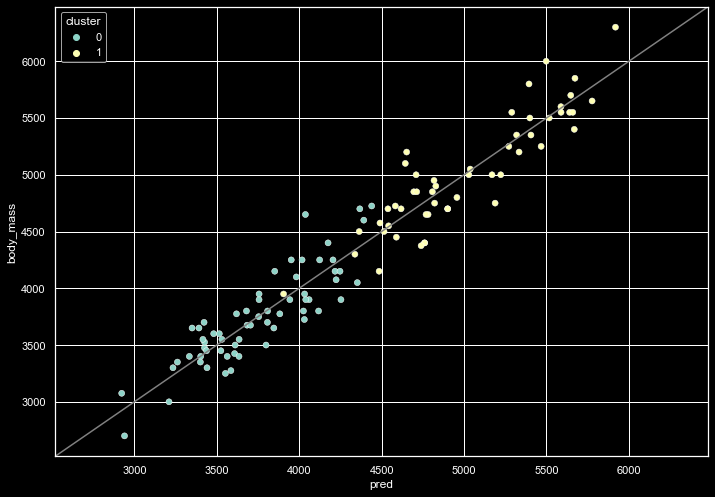

In [85]:
_max = max(train_fn['pred'].max(),train_fn['body_mass'].max())
_min = min(train_fn['pred'].min(),train_fn['body_mass'].min())

sns.scatterplot(train_fn['pred'],train_fn['body_mass'],hue=train_fn['cluster'])
plt.axline((_min,_min),(_max,_max),color='gray')
plt.show()

In [86]:
sub_fn = pd.concat(test_fn,axis=0)[['id','Body Mass (g)']]
sub_fn.sort_index(inplace=True)

sub_fn.to_csv(OUT_PATH + 'out_lr_cluster_nointer.csv', index=False)

<br></br>
## LASSO Regression with Cluster

In [87]:
train_df = train12.copy()
for col in train_df.columns:
    if COL_TYPE[col] not in [int,float]:
        train_df[col].astype(str)
        
test_df  = test12.copy()
for col in test_df.columns:
    if COL_TYPE[col] not in [int,float]:
        test_df[col].astype(str)

train_df = pd.concat([
    onehot_encoding(train_df.drop(['cluster'],axis=1),COL_TYPE),
    train_df['cluster']
],axis=1)

test_df  = pd.concat([
    onehot_encoding(test_df.drop(['cluster'],axis=1),COL_TYPE),
    test_df['cluster']
],axis=1)

train_fn = []
test_fn  = []
for value in train_df['cluster'].unique():
    
    tr_df = train_df[train_df['cluster']==value]
    te_df = test_df [test_df ['cluster']==value]

    model = models_dict['LASSO']
    model.fit(tr_df.drop(['id','body_mass','cluster'],axis=1), 
              tr_df['body_mass'])

    te_df['Body Mass (g)'] = model.predict(te_df.drop(['id','cluster'],axis=1))
    tr_df['pred']          = model.predict(tr_df.drop(['id','body_mass','cluster'],axis=1))
    
    train_fn.append(tr_df)
    test_fn.append(te_df)

In [88]:
train_fn = pd.concat(train_fn,axis=0)[['body_mass','pred','cluster']]
rmse_fn(train_fn['body_mass'].values,train_fn['pred'].values)

263.4048849060808

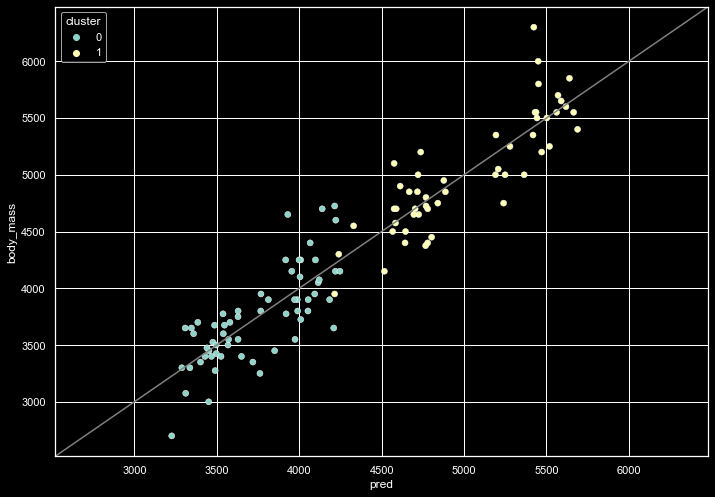

In [89]:
_max = max(train_fn['pred'].max(),train_fn['body_mass'].max())
_min = min(train_fn['pred'].min(),train_fn['body_mass'].min())

sns.scatterplot(train_fn['pred'],train_fn['body_mass'],hue=train_fn['cluster'])
plt.axline((_min,_min),(_max,_max),color='gray')
plt.show()

In [90]:
sub_fn = pd.concat(test_fn,axis=0)[['id','Body Mass (g)']]
sub_fn.sort_index(inplace=True)

sub_fn.to_csv(OUT_PATH + 'out_lasso_cluster_nointer.csv', index=False)

<br></br>
## Ensemble with Cluster

In [91]:
train_df = train12.copy()
for col in train_df.columns:
    if COL_TYPE[col] not in [int,float]:
        train_df[col].astype(str)
        
test_df  = test12.copy()
for col in test_df.columns:
    if COL_TYPE[col] not in [int,float]:
        test_df[col].astype(str)

train_df = pd.concat([
    onehot_encoding(train_df.drop(['cluster'],axis=1),COL_TYPE),
    train_df['cluster']
],axis=1)

test_df  = pd.concat([
    onehot_encoding(test_df.drop(['cluster'],axis=1),COL_TYPE),
    test_df['cluster']
],axis=1)

In [92]:
# (1) cluster as segment
train_fn, test_fn = [],[]
for value in train_df['cluster'].unique():
    
    inter_tr_df = train_df[train_df['cluster']==value]
    inter_te_df = test_df [test_df ['cluster']==value]
    
    no_inter_tr_df = inter_tr_df[[col for col in inter_tr_df.columns if col.find('*')<0]]
    no_inter_te_df = inter_te_df[[col for col in inter_te_df.columns if col.find('*')<0]]
    
    tr_raw_df = inter_tr_df
    te_raw_df = inter_te_df

    pbar = tqdm(models)
    for name,model in pbar:
        pbar.set_description(f'fitting... ({name})')
    
        model_inter   = model
        model_nointer = model
        
        # interaction
        model_inter.fit(inter_tr_df.drop(['id','body_mass','cluster'],axis=1), inter_tr_df['body_mass'])
        
        tr_raw_df[f'1_pred_{name}_inter'] = model_inter.predict(inter_tr_df.drop(['id','body_mass','cluster'],axis=1))
        te_raw_df[f'1_pred_{name}_inter'] = model_inter.predict(inter_te_df.drop(['id','cluster'],axis=1))
        
        # no intercation
        model_nointer.fit(no_inter_tr_df.drop(['id','body_mass','cluster'],axis=1), no_inter_tr_df['body_mass'])
        
        tr_raw_df[f'1_pred_{name}_nointer'] = model_nointer.predict(no_inter_tr_df.drop(['id','body_mass','cluster'],axis=1))
        te_raw_df[f'1_pred_{name}_nointer'] = model_nointer.predict(no_inter_te_df.drop(['id','cluster'],axis=1))

    train_fn.append(tr_raw_df)
    test_fn .append(te_raw_df)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [93]:
# (2) cluster as variable
inter_tr_df = train_df.copy()
inter_te_df = test_df .copy()

no_inter_tr_df = inter_tr_df[[col for col in inter_tr_df.columns if col.find('*')<0]]
no_inter_te_df = inter_te_df[[col for col in inter_te_df.columns if col.find('*')<0]]

tr_raw_df = train_df.copy()
te_raw_df = test_df .copy()

pbar = tqdm(models)
for name,model in pbar:
    pbar.set_description(f'fitting... ({name})')

    model_inter   = model
    model_nointer = model

    # interaction
    model_inter.fit(inter_tr_df.drop(['id','body_mass','cluster'],axis=1), inter_tr_df['body_mass'])

    tr_raw_df[f'2_pred_{name}_inter'] = model_inter.predict(inter_tr_df.drop(['id','body_mass','cluster'],axis=1))
    te_raw_df[f'2_pred_{name}_inter'] = model_inter.predict(inter_te_df.drop(['id','cluster'],axis=1))

    # no intercation
    model_nointer.fit(no_inter_tr_df.drop(['id','body_mass','cluster'],axis=1), no_inter_tr_df['body_mass'])

    tr_raw_df[f'2_pred_{name}_nointer'] = model_nointer.predict(no_inter_tr_df.drop(['id','body_mass','cluster'],axis=1))
    te_raw_df[f'2_pred_{name}_nointer'] = model_nointer.predict(no_inter_te_df.drop(['id','cluster'],axis=1))

  0%|          | 0/12 [00:00<?, ?it/s]

In [102]:
# 1_ : as segment, _2 : as variable
b = a[:5]
b['ratio'] = 1/b['rmse']
b['ratio'] = b['ratio'] / sum(b['ratio'])

b

,rmse,ratio
model,,
1_LASSO_inter,284.169175,0.202676
1_RIDGE_inter,287.105401,0.200603
1_LASSO_nointer,288.640650,0.199536
1_LR_nointer,289.531421,0.198922
1_RIDGE_nointer,290.495744,0.198262


In [105]:
tr_ensemble_df = pd.concat([
    pd.concat(train_fn,axis=0).reset_index(drop=True),
    tr_raw_df[[col for col in tr_raw_df.columns if col.find('2_')>=0]].reset_index(drop=True)
],axis=1)

target_col = [col for col in tr_ensemble_df.columns if (col.find('1_')>=0) or (col.find('2_')>=0) or (col=='body_mass') or (col=='cluster')]

tr_ensemble_df['pred_ensemble'] = tr_ensemble_df[['1_pred_LASSO_inter','1_pred_LR_nointer','1_pred_LASSO_nointer','1_pred_LR_nointer','1_pred_RIDGE_nointer']].apply(
    #lambda x:sum(x)/5,
    lambda x: x[0]*b['ratio'][b.index[0]]+\
              x[1]*b['ratio'][b.index[1]]+\
              x[2]*b['ratio'][b.index[2]]+\
              x[3]*b['ratio'][b.index[3]]+\
              x[4]*b['ratio'][b.index[4]],
    axis=1
)

rmse_fn(tr_ensemble_df['body_mass'],tr_ensemble_df['pred_ensemble'])

249.38687511221667

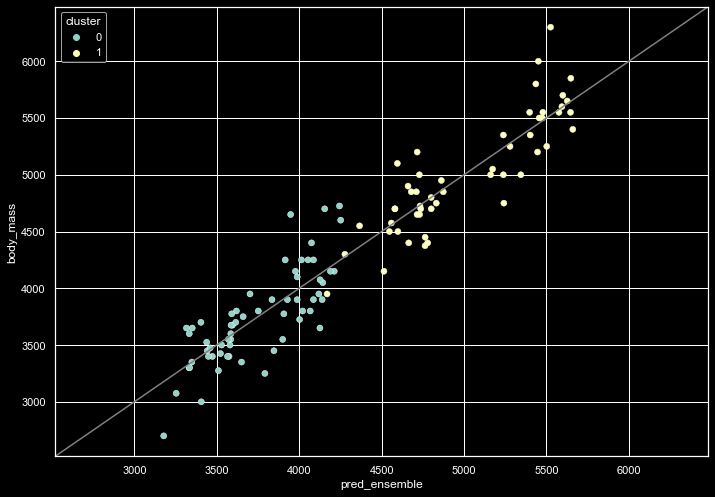

In [106]:
_max = max(tr_ensemble_df['pred_ensemble'].max(),tr_ensemble_df['body_mass'].max())
_min = min(tr_ensemble_df['pred_ensemble'].min(),tr_ensemble_df['body_mass'].min())

sns.scatterplot(tr_ensemble_df['pred_ensemble'],tr_ensemble_df['body_mass'],hue=tr_ensemble_df['cluster'])
plt.axline((_min,_min),(_max,_max),color='gray')
plt.show()

In [107]:
te_ensemble_df = pd.concat([
    pd.concat(test_fn,axis=0).reset_index(drop=True),
    te_raw_df[[col for col in te_raw_df.columns if col.find('2_')>=0]].reset_index(drop=True)
],axis=1)

te_ensemble_df['pred_ensemble'] = te_ensemble_df[['1_pred_LASSO_nointer','1_pred_LR_nointer','1_pred_EN_inter']].apply(
    lambda x:sum(x)/3,
#     lambda x: x[0]*b['ratio'][b.index[0]]+\
#               x[1]*b['ratio'][b.index[1]]+\
#               x[2]*b['ratio'][b.index[2]],
    axis=1
)

In [108]:
sub_fn = te_ensemble_df[['id','pred_ensemble']]
sub_fn.sort_index(inplace=True)

sub_fn.rename(columns = {'pred_ensemble' : 'Body Mass (g)'}, inplace = True)

sub_fn

sub_fn.to_csv(OUT_PATH + 'out_scaled_weighted_ensemble_cluster_2.csv', index=False)

<br></br>
## LGBM setting with Bayesian Optimization

In [ ]:
# bayesian optimization에 쓰일 hyper parameter들의 boundary
bounds_LGB = {
    'num_leaves': (100, 800), 
    'min_data_in_leaf': (0, 150),
    'bagging_fraction' : (0.3, 0.9),
    'feature_fraction' : (0.3, 0.9),
    'min_child_weight': (0.01, 1.),   
    'reg_alpha': (0.01, 1.), 
    'reg_lambda': (0.01, 1),
    'max_depth':(6, 23),
    'learning_rate': (1e-8, 0.05),
}

# bayesian optimazation을 통하여 hyper parameter를 선택한
# lightgbm modelling
def build_lgb(x, y, val_x, val_y,
              init_points=INIT_POINTS, n_iter=N_ITER, cv=N_CV, 
              ret_param=True, verbose=-1, is_test=False, 
              SEED=SEED, objective = OBJECTIVE):
    
    # verbose : 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
    
    # set reg options
    if objective=='regression':
        ML = lgb.LGBMRegressor
    elif objective=='binary':
        ML = lgb.LGBMClassifier
    
    # (1) 각 hyper parameter들의 lgb model의 f1 score를 return
    def LGB_bayesian(
        num_leaves, 
        bagging_fraction,
        feature_fraction,
        min_child_weight, 
        min_data_in_leaf,
        max_depth,
        reg_alpha,
        reg_lambda,
        learning_rate,
        objective = OBJECTIVE
        ):
        # LightGBM expects next three parameters need to be integer. 
        num_leaves       = int(num_leaves)
        min_data_in_leaf = int(min_data_in_leaf)
        max_depth        = int(max_depth)

        assert type(num_leaves)       == int
        assert type(min_data_in_leaf) == int
        assert type(max_depth)        == int

        params = {
            'num_leaves': num_leaves, 
            'min_data_in_leaf': min_data_in_leaf,
            'min_child_weight': min_child_weight,
            'bagging_fraction' : bagging_fraction,
            'feature_fraction' : feature_fraction,
            'learning_rate' : learning_rate,
            'max_depth': max_depth,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'objective': objective,
            'save_binary': True,
            'seed': SEED,
            'feature_fraction_seed': SEED,
            'bagging_seed': SEED,
            'drop_seed': SEED,
            'data_random_seed': SEED,
            'boosting': 'gbdt', 
            'verbose': -1,
            'boost_from_average': True,
            'metric':METRIC,
            'n_estimators': N_ESTIMATORS, # 1000
            'n_jobs': -1,
        }    
        
        model = ML(**params)
        model.fit(x, y, eval_set=(val_x, val_y), early_stopping_rounds=30, verbose=-1)
        pred = model.predict(val_x)
        score = rmse_fn(val_y, pred)
        return -score
    
    # (2) Get hyper parameter by bayesian optimazation
    optimizer = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=SEED, verbose=-1)
    
    # initial point, n_iter에 대해서 maximize 하는 bayesian optimazation 실행
    optimizer.maximize(init_points=init_points, n_iter=n_iter)#, acq='ei', xi=0.01)
    # init_points는 처음 탐색 횟수. 
    # pbound에서 설정한 구간 내에서 init_points 만큼 입력값을 샘플링하여 계산이 진행
    # n_iter은 연산 횟수입니다. 따라서 총 25번을 수행
    # xi는 exploration-explotation의 강도를 조절하는 인수로 일반적으로 0.01로 설정하여 exploration을 높여줌
    
    
    # (3) bayesian optimazation를 통해서 얻은 hyper parameter
    param_lgb = {
        'min_data_in_leaf': int(optimizer.max['params']['min_data_in_leaf']), 
        'num_leaves': int(optimizer.max['params']['num_leaves']), 
        'learning_rate': optimizer.max['params']['learning_rate'],
        'min_child_weight': optimizer.max['params']['min_child_weight'],
        'bagging_fraction': optimizer.max['params']['bagging_fraction'], 
        'feature_fraction': optimizer.max['params']['feature_fraction'],
        'reg_lambda': optimizer.max['params']['reg_lambda'],
        'reg_alpha': optimizer.max['params']['reg_alpha'],
        'max_depth': int(optimizer.max['params']['max_depth']), 
        'objective': objective,
        #'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting': 'gbdt', 
        'verbose': -1,
        'boost_from_average': True,
        'metric': METRIC, #'auc',
        'n_estimators': N_ESTIMATORS, # 1000
        'n_jobs': -1,
    }

    # final parameter
    params = param_lgb.copy()
    
    # final model
    model = ML(**params)
    model.fit(x, y, eval_set=(val_x, val_y), early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              callbacks = [lgb.early_stopping(10, verbose=-1), lgb.log_evaluation(period=-1)])
    
    if ret_param:
        return model, params
    else:
        return model

<br></br>
##### segment and dataset setting

In [ ]:
# ca==cp > exang > slope > sex
# > ca는 2,3건수가 너무적음
# > cp는 1,3건수가 너무 적음
seg_var = ['cluster']

# 각 세그별 최소 건수
#[train12[seg_var_x].value_counts().min() for seg_var_x in seg_var]
cnt(train12['cluster'])

<br></br>
## LGBM fitting

In [ ]:
import optuna
from optuna.integration import LightGBMPruningCallback

def objective(trial, _X, _y, objective = 'regression'):
    
    N_SPLIT = 5
    
    # set reg options
    if objective=='regression':
        ML = lgb.LGBMRegressor
    elif objective=='binary':
        ML = lgb.LGBMClassifier
    
    # optuna hyper-parameter grid
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1e-2),
        'num_leaves': trial.suggest_int('num_leaves', 5, 100, step=5),
        'max_depth': trial.suggest_int('max_depth', 1, 30, step=2),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 1000, step=50),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100, step=5),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100, step=5),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1, 30, step=3),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.99, step=0.1),
        'bagging_freq': trial.suggest_categorical('bagging_freq',[1]),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 0.99, step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 3000, step=5),
        
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        
        'boosting': 'gbdt', 
        'verbose': -1,
        #'verbose_eval': -1,
        'boost_from_average': True,
        'n_jobs': -1,
        
        'objective' : OBJECTIVE,
    }

    # cross validation
    cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=False)#, random_state=SEED)

    # cross validation score
    cv_scores = np.empty(N_SPLIT)
    
    # cv를 통해서 lgb적합해서 최적의 hyper-parameter 확인
    for idx, (_train_idx, _test_idx) in enumerate(cv.split(_X, _y)):
        _X_train, _X_test = _X.iloc[_train_idx], _X.iloc[_test_idx]
        _y_train, _y_test = _y[_train_idx], _y[_test_idx]

        model = ML(**param_grid)
        model.fit(
            _X_train,
            _y_train,
            verbose = -1,
            eval_set=[(_X_test, _y_test)],
            eval_metric='rmse',
            early_stopping_rounds=30,
            callbacks=[
                LightGBMPruningCallback(trial, 'rmse')
            ],  # Add a pruning callback
        )
        _preds = model.predict(_X_test)
        cv_scores[idx] = rmse_fn(_y_test, _preds)

    #return np.mean(f1_scores)
    return np.mean(cv_scores)

In [ ]:
start_time = time.time()

train_df = train12.copy()
test_df  = test12 .copy()

# set reg options
if OBJECTIVE=='regression':
    ML = lgb.LGBMRegressor
elif OBJECTIVE=='binary':
    ML = lgb.LGBMClassifier

for seg_var_x in seg_var:

    train_df[seg_var_x+'_pred'] = np.nan
    test_df [seg_var_x+'_pred'] = np.nan

    #---------------------------------------------------------------------------------------#
    # remove needless variable
    #---------------------------------------------------------------------------------------#
    drop_var = ['id','body_mass'] +\
    [seg_var_x           for seg_var_x in seg_var] +\
    [seg_var_x+'_pred'   for seg_var_x in seg_var]

    X_train = train_df[list(set(train_df.columns)-set(drop_var))]
    X_test  = test_df [list(set(test_df.columns) -set(drop_var))]

    y_train = train_df['body_mass'].astype(float).values

    #---------------------------------------------------------------------------------------#
    # feature importance
    #---------------------------------------------------------------------------------------#
    model = ML(seed = SEED)
    model.fit(X_train, y_train, verbose=-1)

    feature_imp = pd.DataFrame(zip(X_train.columns,
                                   model.feature_importances_.astype(float)), 
                               columns=['feature','imp']).sort_values(by='imp')

    reduced_var = list(feature_imp.feature[feature_imp.imp>1])

    X_train_new = X_train[reduced_var]
    X_test_new  = X_test [reduced_var]
    
    del model

    #---------------------------------------------------------------------------------------#
    # modelling
    #---------------------------------------------------------------------------------------#
    study = optuna.create_study(direction='minimize', study_name='LGBM Regressor')
    func = lambda trial: objective(trial, X_train_new, y_train)
    study.optimize(func, n_trials=20)

    model = ML(**study.best_params)
    model.fit(X_train_new,y_train)

    # seg별 predict값 넣기
    train_df[seg_var_x+'_pred'] = model.predict(X_train_new)
    test_df [seg_var_x+'_pred'] = model.predict(X_test_new)

end_time = time.time()

In [ ]:
rmse_fn(train_df['cluster_pred'],train_df['body_mass'])
train_df['cluster_pred'].value_counts()

<br></br>
### Cluster 포함 전체 Fitting

In [ ]:
start_time = time.time()

train_df = train12.copy()
test_df  = test12 .copy()

for seg_var_x in seg_var:

    train_df[seg_var_x+'_pred'] = np.nan
    test_df [seg_var_x+'_pred'] = np.nan

    #---------------------------------------------------------------------------------------#
    # remove needless variable
    #---------------------------------------------------------------------------------------#
    drop_var = ['id','body_mass'] +\
    [seg_var_x           for seg_var_x in seg_var] +\
    [seg_var_x+'_pred'   for seg_var_x in seg_var]

    X_train = train_df[list(set(train_df.columns)-set(drop_var))]
    X_test  = test_df [list(set(test_df.columns) -set(drop_var))]

    y_train = train_df['body_mass'].astype(float).values

    #---------------------------------------------------------------------------------------#
    # feature importance
    #---------------------------------------------------------------------------------------#
    model = lgb.LGBMRegressor(seed = SEED)
    model.fit(X_train, y_train, verbose=-1)

    feature_imp = pd.DataFrame(zip(X_train.columns,
                                   model.feature_importances_.astype(float)), 
                               columns=['feature','imp']).sort_values(by='imp')

    reduced_var = list(feature_imp.feature[feature_imp.imp>1])

    X_train_new = X_train[reduced_var]
    X_test_new  = X_test [reduced_var]

    #---------------------------------------------------------------------------------------#
    # modelling
    #---------------------------------------------------------------------------------------#
    n_fold = 5
    sf = StratifiedKFold(n_fold, shuffle=True, random_state=SEED)

    y_tr = []
    y_te = []

    c = 1
    for tr_idx, val_idx in sf.split(X_train_new, y_train):

        tr_nunique = X_train_new.iloc[tr_idx ]\
        [[col for col in X_train_new.columns if COL_TYPE[col]==str]]\
        .apply(lambda x:x.nunique()).values

        va_nunique = X_train_new.iloc[val_idx]\
        [[col for col in X_train_new.columns if COL_TYPE[col]==str]]\
        .apply(lambda x:x.nunique()).values

        match_nunique = np.array([col for col in X_train_new.columns if COL_TYPE[col]==str])[[tr_nunique != va_nunique]]

        if len(match_nunique)>0:
            for col in match_nunique:
                del X_train_new[col]

        print('#'*25, f'CV {c}')

        #X_tr = onehot_encoding(X_train_new, COL_TYPE)
        #X_te = onehot_encoding(X_test_new , COL_TYPE)

        X_tr = X_train_new.copy()
        X_te = X_test_new .copy()

        model = build_lgb(x = X_tr.iloc[tr_idx ], 
                          y = y_train[tr_idx ], 
                          val_x = X_tr.iloc[val_idx], 
                          val_y = y_train[val_idx],
                          init_points=INIT_POINTS, n_iter=N_ITER, cv=N_CV, 
                          ret_param=False, is_test=False, 
                          SEED=SEED,
                          objective = OBJECTIVE)

        y_tr_0 = model.predict(X_tr)
        y_te_0 = model.predict(X_te)

        y_tr.append(y_tr_0)
        y_te.append(y_te_0)

        c += 1

    # seg별 predict값 넣기
    train_df[seg_var_x+'_pred'] = np.median(y_tr,0)
    test_df [seg_var_x+'_pred'] = np.median(y_te,0)

end_time = time.time()

In [ ]:
rmse_fn(train_df['cluster_pred'],train_df['body_mass'])

In [ ]:
sns.scatterplot(train_df['body_mass'],train_df['cluster_pred'],hue=train_df['cluster'])
plt.axline((train_df['body_mass'].min(),train_df['body_mass'].min()),
           (train_df['body_mass'].max(),train_df['body_mass'].max()), 
           color='gray')

In [ ]:
sub = test_df[['id','cluster_pred']].rename(columns={'cluster_pred':'Body Mass (g)'})
sub

sub.to_csv(OUT_PATH + 'out_lgbm_with_cluster.csv', index=False)

<br></br>
### Cluster별로 Fitting

In [ ]:
start_time = time.time()

train_df = train12.copy()
test_df  = test12 .copy()

for seg_var_x in seg_var:

    train_df[seg_var_x+'_pred']   = np.nan
    test_df [seg_var_x+'_pred']   = np.nan

    # segment별로 modelling
    for iter in range(0,len(train_df[seg_var_x].value_counts().index)):

        # segment setting
        seg_var_value = train_df[seg_var_x].value_counts().index[iter]

        # data setting
        tr_seg_df = train_df[train_df[seg_var_x] == seg_var_value]
        te_seg_df = test_df [test_df [seg_var_x] == seg_var_value]

        drop_var = ['id','body_mass'] +\
        [seg_var_x           for seg_var_x in seg_var] +\
        [seg_var_x+'_pred'   for seg_var_x in seg_var] +\
        [seg_var_x+'_tr_idx' for seg_var_x in seg_var]

        X_train = tr_seg_df[list(set(tr_seg_df.columns)-set(drop_var))]
        X_test  = te_seg_df[list(set(te_seg_df.columns)-set(drop_var))]

        y_train = tr_seg_df['body_mass'][tr_seg_df[seg_var_x] == seg_var_value].astype(float).values

            
        # feature importance
        model = lgb.LGBMRegressor(seed = SEED)
        model.fit(X_train, y_train, verbose=-1)

        feature_imp = pd.DataFrame(zip(X_train.columns,
                                       model.feature_importances_.astype(float)), 
                                   columns=['feature','imp']).sort_values(by='imp')
            
        reduced_var = list(feature_imp.feature[feature_imp.imp>1])

        X_train_new = X_train[reduced_var]
        X_test_new  = X_test [reduced_var]
        
        # modelling
        n_fold = 4
        sf = StratifiedKFold(n_fold, shuffle=True, random_state=SEED)

        y_tr = []
        y_te = []

        c = 1
        for tr_idx, val_idx in sf.split(X_train_new, y_train):

            tr_nunique = X_train_new.iloc[tr_idx ]\
            [[col for col in X_train_new.columns if COL_TYPE[col]==str]]\
            .apply(lambda x:x.nunique()).values
            
            va_nunique = X_train_new.iloc[val_idx]\
            [[col for col in X_train_new.columns if COL_TYPE[col]==str]]\
            .apply(lambda x:x.nunique()).values

            match_nunique = np.array([col for col in X_train_new.columns if COL_TYPE[col]==str])[[tr_nunique != va_nunique]]
            
            if len(match_nunique)>0:
                for col in match_nunique:
                    del X_train_new[col], X_test_new[col]
                
            print('#'*25, f'CV {c}')
            
            X_tr = X_train_new.copy()
            X_te = X_test_new .copy()
            
            model = build_lgb(x = X_tr.iloc[tr_idx ], 
                              y = y_train[tr_idx ], 
                              val_x = X_tr.iloc[val_idx], 
                              val_y = y_train[val_idx],
                              init_points=INIT_POINTS, n_iter=N_ITER, cv=N_CV, 
                              ret_param=False, is_test=False, 
                              SEED=SEED)

            y_tr_0 = model.predict(X_tr)
            y_te_0 = model.predict(X_te)

            y_tr.append(y_tr_0)
            y_te.append(y_te_0)

            c += 1

        # seg별 predict값 넣기
        train_df[seg_var_x+'_pred'][train_df[seg_var_x] == seg_var_value] = np.median(y_tr,0) # np.where(np.mean(y_tr, 0)>0.5, 1, 0)
        test_df [seg_var_x+'_pred'][test_df [seg_var_x] == seg_var_value] = np.median(y_te,0) # np.where(np.mean(y_te, 0)>0.5, 1, 0)
        
end_time = time.time()

In [ ]:
rmse_fn(train_df['cluster_pred'],train_df['body_mass'])

In [ ]:
sns.scatterplot(train_df['body_mass'],train_df['cluster_pred'],hue=train_df['cluster'])
plt.axline((train_df['body_mass'].min(),train_df['body_mass'].min()),
           (train_df['body_mass'].max(),train_df['body_mass'].max()), 
           color='gray')

In [ ]:
sub = test_df[['id','cluster_pred']].rename(columns={'cluster_pred':'Body Mass (g)'})
sub

sub.to_csv(OUT_PATH + 'out_lgbm_segby_cluster.csv', index=False)

<br></br>
##### seg별 confusion matrix and f1_score

In [ ]:
for seg_var_x in seg_var:
    
    tr_pred = train_df[f'{seg_var_x}_pred']
    tr_true = train_df.target.astype(int).values
    tr_f1   = f1_score(tr_pred,tr_true)
    
    print('-'*50)
    print(f'{seg_var_x} - f1_score : {tr_f1:.2f}')
    print(pd.crosstab(tr_pred,tr_true))

<br></br>
##### train_df 저장

In [ ]:
# train_df.to_csv(OUT_PATH + 'train_df(2).csv', index=False)

In [ ]:
train_df

<br></br>
##### 각 seg별 f1_score

In [ ]:
f1_score_list = []
for seg_var_x in seg_var:
    f1 = f1_score(train_df[[seg_var_x + '_pred']].astype(int).values,train_df.target.astype(int).values)
    n_blank = ' '*(max_char_len-len(seg_var_x))
    
    if seg_var_x==seg_var[0]: print(' '*max_char_len, 'f1_score')
    print(f'{seg_var_x} {n_blank} {f1: .3f}')
    
    f1_score_list.append(f1)

<br></br>
##### 각 segment의 weight

In [ ]:
weight = [f/sum(f1_score_list) for f in f1_score_list]
for seg,w in zip(seg_var,weight):
    n_blank = ' '*(max_char_len-len(seg))
    if seg==seg_var[0]: print(' '*max_char_len, '  weight')
    print(f'{seg} {n_blank} {w*100: .1f}%')

<br></br>
##### weighted predicted value : [1,0]의 조합이라서 똑같음

In [ ]:
# (1) mixed
tr_pred_mix = train_df[[seg + '_pred' for seg in seg_var]].sum(axis=1)/len(seg_var)
tr_f1_score_mix = f1_score(np.where(tr_pred_mix>0.5,1,0), train_df.target.astype(int).values)

# (2) weighted mixed
tr_pred_weighted_mix = np.array([train_df[seg+'_pred'].astype(int).values*weight[iter] 
                                 for iter,seg in enumerate(['is_ca', 'is_cp', 'sex', 'exang', 'slope2'])]).sum(axis=0)
tr_f1_score_weighted_mix = f1_score(np.where(tr_pred_weighted_mix>0.5,1,0), train_df.target.astype(int).values)

print(f'f1_score of          mixed segment predicted value:{tr_f1_score_mix         : .3f}')
print(f'f1_score of weighted mixed segment predicted value:{tr_f1_score_weighted_mix: .3f}')

# a=pd.DataFrame({'x' : np.where(tr_pred_mix>0.5,1,0),
#                 'y' : np.where(tr_pred_weighted_mix>0.5,1,0)})
# pd.crosstab(a.x,a.y)

<br></br>
##### seg들을 조합해서 pred 생성

In [ ]:
train_df['tr_pred_mix'] = np.where(train_df[[seg + '_pred' for seg in seg_var]].sum(axis=1)/len(seg_var)>0.5, '1', '0')
test_df ['te_pred_mix'] = np.where(test_df [[seg + '_pred' for seg in seg_var]].sum(axis=1)/len(seg_var)>0.5, '1', '0')

<br></br>
##### confusion matrix and f1_score

In [ ]:
f1 = f1_score(train_df['tr_pred_mix'].astype(int).values,train.target.astype(int).values)
print(f'f1_score : {f1:.3f}\n')
print(pd.crosstab(train_df['tr_pred_mix'],train.target))

' / '.join([f'{var}:{eval(var)}' for var in ini_var])


# f1 : 0.899 ('SEED:777 / INIT_POINTS:15 / N_ITER:15 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:True / INTERACTION:True')
# f1 : 0.859 ('SEED:777 / INIT_POINTS:15 / N_ITER:15 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:True / INTERACTION:False')

# f1 : 0.897 ('SEED:777 / INIT_POINTS:15 / N_ITER:15 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:False / INTERACTION:True')
# f1 : 0.877 ('SEED:777 / INIT_POINTS:15 / N_ITER:15 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:False / INTERACTION:False')

# f1 : 0.920 ('SEED:777 / INIT_POINTS:45 / N_ITER:100 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:True / INTERACTION:True')
# f1 : 0.860 ('SEED:777 / INIT_POINTS:50 / N_ITER:200 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:auc / PLOT:False / SCALE:True / INTERACTION:True')

# f1 : 0.907 ('SEED:777 / INIT_POINTS:50 / N_ITER:300 / N_CV:4 / EARLY_STOPPING_ROUNDS:30 / N_ESTIMATORS:2000 / METRIC:binary_logloss / PLOT:False / SCALE:True / INTERACTION:True')

In [ ]:
test_df['te_pred_mix'].value_counts()

In [ ]:
sub['target'] = ['1' if pred=='1' else '0' for pred in test_df['te_pred_mix']]
sub.target.value_counts()

In [ ]:
# 점수 : 0.92537
# sub.to_csv(OUT_PATH + 'sample_18.csv', index=False)

In [ ]:
a=pd.read_csv(OUT_PATH + '★sample_9_mixed.csv')
b=sub

print(pd.crosstab(a.target,b.target))
print(f1_score(a.target.astype(int).values,b.target.astype(int).values))

